In [1]:
#Importing necessary libraries 
import os
import pandas as pd
import matplotlib.pyplot as plt
from fastai.vision.all import *
from sklearn.utils import resample
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import glob
import numpy as np
import pydicom
import cv2
from sklearn.model_selection import KFold

#Convert a 16-bit DICOM image to 8-bit format for visualization
def convert_to_8bit(x):
    lower, upper = np.percentile(x, (1, 99)) #Get the 1st and 99th percentile of pixel values
    x = np.clip(x, lower, upper)   #clip outer parts
    x = x - np.min(x)
    x = x / np.max(x)         #normalize to 0-1 range
    return (x * 255).astype("uint8")      #return in 8-bit

#Load and convert DICOM images into pixel matrix dictionary
def load_dicom_stack(dicom_folder, plane, reverse_sort=False, target_shape=(256, 256)):
    dicom_files = glob.glob(os.path.join(dicom_folder, "*.dcm"))          #load all dicom files from the folder path
    dicoms = [pydicom.dcmread(f) for f in dicom_files]                   #read files with pydicom 
    plane = {"sagittal": 0, "coronal": 1, "axial": 2}[plane.lower()]          #find the plane of the image ( 0 if plane= sagittal) and sort images based on position
    positions = np.asarray([float(d.ImagePositionPatient[plane]) for d in dicoms])
    idx = np.argsort(-positions if reverse_sort else positions)
    ipp = np.asarray([d.ImagePositionPatient for d in dicoms]).astype("float")[idx]
    
    #convert pizel array to float and resize shape and convert it into 3D np array
    arrays = []
    for d in dicoms:
        img = d.pixel_array.astype("float32")
        if img.shape != target_shape:
            img = cv2.resize(img, target_shape, interpolation=cv2.INTER_AREA)
        arrays.append(img)
    
    array = np.stack(arrays)
    array = array[idx]
    return {"array": convert_to_8bit(array), "positions": ipp, "pixel_spacing": np.asarray(dicoms[0].PixelSpacing).astype("float")}     #dictionary of image data

In [2]:
# to print images from each category
def show_images_from_category(df, category, n=6):
    fig, axes = plt.subplots(1, n, figsize=(20, 5))
    for ax, (idx, row) in zip(axes, df[df.label == category].sample(n).iterrows()):
        img = plt.imread(row['image'])
        ax.imshow(img, cmap='gray')
        ax.set_title(category)
        ax.axis('off')

In [3]:
#DATA PREPROCESSING

# upsample minority classes of existing data
#arguments: train data set and the column to be upsampled
#returns upsampled dataset
def preprocess_data_for_column(train, column):
    print("Preprocessing data (upsampling) for ", column)
    df = train[['study_id', 'series_id', column]].dropna(subset=[column])      #drop rows with null values
    df.columns = ['study_id', 'series_id', 'label']          #column renamed as label here

    #divide ddf into three according to the classes
    normal_df = df[df.label == 'Normal/Mild']
    moderate_df = df[df.label == 'Moderate']
    severe_df = df[df.label == 'Severe']

    moderate_upsampled = resample(moderate_df, replace=True, n_samples=len(normal_df), random_state=42)        #upsamle maderate class
    severe_upsampled = resample(severe_df, replace=True, n_samples=len(normal_df), random_state=42)           #upsample severe class

    upsampled_df = pd.concat([normal_df, moderate_upsampled, severe_upsampled])                #combine all (normal_df is not upsampled because its length > other two)
    print("Length stats of ", column, ":", len(normal_df), " ", len(moderate_upsampled), " ", len(severe_upsampled))
    return upsampled_df

In [4]:
#Get upsampled training data and save DICOM converted PNG images to temp path for every study ID through batches
def prepare_image_paths_and_labels(upsampled_train, save_path, batch_size=1000, start_batch=0):
    
    os.makedirs(os.path.dirname(save_path), exist_ok=True)                    #create non-existing directories
    print("Preparing image paths and labels for current column")

    #loads the dicom images and saves the middle slice as png in a temp directory for each row (image_dir here is a global variable which defines the image directory)
    def process_row(row, count):
        series_folder = os.path.join(image_dir, str(row.study_id), str(row.series_id))
        dicom_stack = load_dicom_stack(series_folder, plane="sagittal")
        middle_slice = dicom_stack["array"][len(dicom_stack["array"]) // 2]
        image_path = f"/tmp/{row.study_id}_{count}.png"  # Ensure unique filename to save as png
        plt.imsave(image_path, middle_slice, cmap="gray")
        return image_path, row.label               #a tuple of the row's image path and its label is returned

    total_batches = (len(upsampled_train) // batch_size) + 1    #divide the upsampled images into a number of batches (default batch size is 1000)

    for batch_num in range(start_batch, total_batches):

        batch_save_path = f"{save_path}_batch_{batch_num}.csv"     #for storing batches as a future proof if program fails in between

        #create lists to store the image paths and its corresponding labels (Normal/Mild, Moderate, Severe) of a particular column
        image_paths = []                                   
        labels = []
        #Check if the batch file already exists in its batch save path
        if os.path.exists(batch_save_path):
            print(f"Batch {batch_num} already processed. Skipping...")
            continue
        
        #find start and end index of the batch and store the batch data in a dataframe
        batch_start = batch_num * batch_size
        batch_end = min((batch_num + 1) * batch_size, len(upsampled_train))
        batch_df = upsampled_train.iloc[batch_start:batch_end]

        #CONCURRENT PROCESSING - MULTITHREADING TO RUN SIMULTANEOUS PROCESSES
        with ThreadPoolExecutor(max_workers=8) as executor:
            futures = []
            for count, row in enumerate(tqdm(batch_df.itertuples(), total=len(batch_df)), start=1):
                futures.append(executor.submit(process_row, row, count))            #process row and append results in futures (a list of tuples)

            for future in tqdm(futures, total=len(futures)):
                image_path, label = future.result()                  #extract the tuple values i.e. image paths and labels of each row and append them to their list
                image_paths.append(image_path)
                labels.append(label)
        try:
            pd.DataFrame({"image": image_paths, "label": labels}).to_csv(batch_save_path, index=False) #save dataframe as csv in a path created
            print(f"Saved batch {batch_num} to {batch_save_path}")

        except OSError as e:
            print(f"Error saving CSV: {e}")
        
    #Combine all batches into a single CSV
    all_batches = [pd.read_csv(f"{save_path}_batch_{i}.csv") for i in range(start_batch, total_batches)]
    full_data_df = pd.concat(all_batches, ignore_index=True)
    full_data_df.to_csv(save_path, index=False)
    print(f"Saved full dataset to {save_path}")
    #return the full data for training after labeling each images
    return full_data_df

In [5]:
#Load previously created image paths-labels if any
def load_image_paths_and_labels(csv_path):
    return pd.read_csv(csv_path)

#Train a model on a particular column and data containing the image paths and its labels. Returns the learner and its accuracy
def train_model_for_column(column, data, max_epochs=4):
    print(f"Training model for the column {column} ")
    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),       #define datablocks (here image and its category)
        get_x=ColReader('image'),                 #input function
        get_y=ColReader('label'),                 #get label function
        splitter=RandomSplitter(valid_pct=0.2, seed=42),          #split data into train and validation set (here random split of 80:20 ratio)
        item_tfms=Resize(256),                    #resize images
        batch_tfms=aug_transforms()               #apply standard data augmentation
    )
    
    print(f"Length of data training: {len(data)}")

    dls = dblock.dataloaders(data)              #create data loaders and cnn learner (using resnet34 here)

    learn = cnn_learner(dls, resnet34, metrics=accuracy)
    
    # find optimal learning rate
    lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
    print(f"Suggested learning rates - min: {lr_min}, steep: {lr_steep}, valley: {lr_valley}, slide: {lr_slide}")
    
    learn.fine_tune(max_epochs, base_lr=lr_valley)            #train the model  (default max epochs 4)
    
    #Evaluate accuracy
    interp = ClassificationInterpretation.from_learner(learn)
    interp.plot_confusion_matrix()
    plt.show()
    
    accuracy_value = accuracy(*learn.get_preds()).item()
    return learn, accuracy_value                 #return the fine tuned learner and its accuracy

In [6]:
from fastai.vision.all import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#Implement single split(to reduce run time) cross-validation and return learner and its accuracy
def cross_validate_model(data, column, max_epochs=4):
    # Split the data into training and validation sets
    train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)          

    #find optimal learning rate once
    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_x=ColReader('image'),
        get_y=ColReader('label'),
        splitter=IndexSplitter(val_data.index),
        item_tfms=Resize(256),
        batch_tfms=aug_transforms()
    )
    dls = dblock.dataloaders(data)
    learn = cnn_learner(dls, resnet34, metrics=accuracy, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])
    
    lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
    print(f"Suggested learning rates - min: {lr_min}, steep: {lr_steep}, valley: {lr_valley}, slide: {lr_slide}")

    #train the model using the optimal learning rate
    learn.fine_tune(max_epochs, base_lr=lr_valley)

    #Evaluate accuracy and plot confusion matrix
    interp = ClassificationInterpretation.from_learner(learn)
    interp.plot_confusion_matrix()
    plt.show()

    accuracy_value = accuracy(*learn.get_preds()).item()
    return learn, accuracy_value

In [7]:
# Preprocess and train models for each column
def preprocess_and_train(df, columns, temp_image_dir, batch_size=1000, start_batch=0):
    results = {}
    accuracy_threshold = 0.91
    print("Currently preprocessing and training Sagittal T1")

    #looping through each column
    for column in columns:
        csv_path = os.path.join(temp_image_dir, f"{column}_image_paths_labels.csv")
        #if path exists, load image paths and its labels from existing directory
        if os.path.exists(csv_path):
            print("Path exists!")
            data = load_image_paths_and_labels(csv_path)
            print(f"Loaded data for column: {column} from {csv_path}")
        else:
            print(f"New path creation for column {column}.")
            df_balanced = preprocess_data_for_column(df, column)            #upsample first
            data = prepare_image_paths_and_labels(df_balanced, csv_path, batch_size=batch_size, start_batch=start_batch)        #then create labels for images in batches
            print(f"Processed and saved data for column: {column} to {csv_path}")
        
        learn,accuracy = cross_validate_model(data, column)     #first cross validate and obtain the accuracy (this time one accuracy is returned due to single fold)
        mean_accuracy = accuracy                                #get mean of all accuracies (here oly one value)

        #expected accuracy- >95%
        if mean_accuracy <= 0.95:

            #Adjust epochs if accuracy is less than the threshold
            epochs = 5 if mean_accuracy >= accuracy_threshold else 10
            learn, accuracy_value = train_model_for_column(column, data, max_epochs=epochs)
            results[column] = learn
        else:
            learn, accuracy_value = train_model_for_column(column, data)
            results[column] = learn
    
    return results       #return the dictionary of column:learner model as key:value

In [8]:
# Load the data
train = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv')
series_description = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')
image_dir = "/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images"

In [9]:
# Merge with series_description.csv to get series_id
train = train.merge(series_description, on='study_id')

#Filter for Sagittal T1 images (change this to train model for Axial T2 or Sagittal T2 images)
train = train[train['series_description'] == 'Sagittal T1']
print("Total Cases:", len(train))

#these are the columns which we need to predict
columns_to_predict = [ 'spinal_canal_stenosis_l1_l2',
'spinal_canal_stenosis_l2_l3', 'spinal_canal_stenosis_l3_l4',
'spinal_canal_stenosis_l4_l5', 'spinal_canal_stenosis_l5_s1',
'left_neural_foraminal_narrowing_l1_l2',
'left_neural_foraminal_narrowing_l2_l3',
'left_neural_foraminal_narrowing_l3_l4',
'left_neural_foraminal_narrowing_l4_l5',
'left_neural_foraminal_narrowing_l5_s1',
'right_neural_foraminal_narrowing_l1_l2',
'right_neural_foraminal_narrowing_l2_l3',
'right_neural_foraminal_narrowing_l3_l4',
'right_neural_foraminal_narrowing_l4_l5',
'right_neural_foraminal_narrowing_l5_s1',
'left_subarticular_stenosis_l1_l2', 'left_subarticular_stenosis_l2_l3',
'left_subarticular_stenosis_l3_l4', 'left_subarticular_stenosis_l4_l5',
'left_subarticular_stenosis_l5_s1', 'right_subarticular_stenosis_l1_l2',
'right_subarticular_stenosis_l2_l3',
'right_subarticular_stenosis_l3_l4',
'right_subarticular_stenosis_l4_l5',
'right_subarticular_stenosis_l5_s1']

Total Cases: 1980


In [10]:
# Set the directory to save image paths and labels
temp_image_dir = "/kaggle/working/CurrentLabels"



Currently preprocessing and training Sagittal T1
New path creation for column spinal_canal_stenosis_l1_l2.
Preprocessing data (upsampling) for  spinal_canal_stenosis_l1_l2
Length stats of  spinal_canal_stenosis_l1_l2 : 1892   1892   1892
Preparing image paths and labels for current column


100%|██████████| 1000/1000 [05:06<00:00,  3.26it/s]


Saved batch 0 to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l1_l2_image_paths_labels.csv_batch_0.csv


100%|██████████| 1000/1000 [04:55<00:00,  3.38it/s]


Saved batch 1 to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l1_l2_image_paths_labels.csv_batch_1.csv


100%|██████████| 1000/1000 [05:04<00:00,  3.28it/s]


Saved batch 2 to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l1_l2_image_paths_labels.csv_batch_2.csv


100%|██████████| 1000/1000 [04:46<00:00,  3.49it/s]


Saved batch 3 to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l1_l2_image_paths_labels.csv_batch_3.csv


100%|██████████| 1000/1000 [04:38<00:00,  3.59it/s]


Saved batch 4 to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l1_l2_image_paths_labels.csv_batch_4.csv


100%|██████████| 676/676 [03:10<00:00,  3.55it/s]


Saved batch 5 to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l1_l2_image_paths_labels.csv_batch_5.csv
Saved full dataset to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l1_l2_image_paths_labels.csv
Processed and saved data for column: spinal_canal_stenosis_l1_l2 to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l1_l2_image_paths_labels.csv


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 73.6MB/s]


Suggested learning rates - min: 0.006918309628963471, steep: 1.3182567499825382e-06, valley: 0.0008317637839354575, slide: 0.0020892962347716093


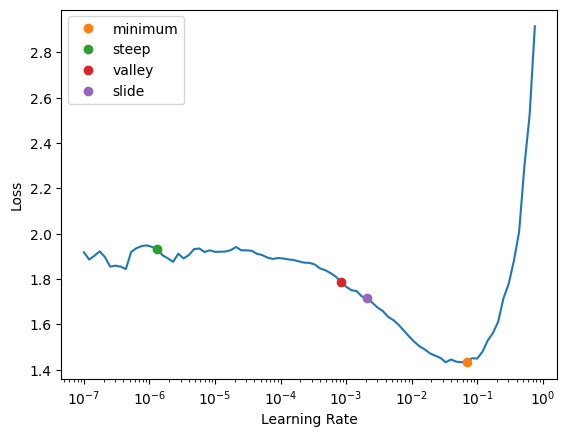

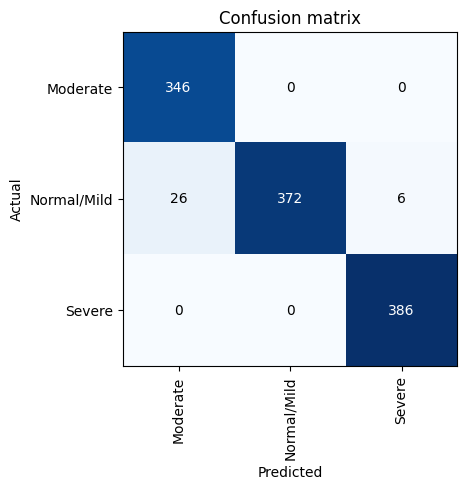

Training model for the column spinal_canal_stenosis_l1_l2 
Length of data training: 5676


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.005754399299621582, steep: 0.0012022644514217973, valley: 0.0008317637839354575, slide: 0.002511886414140463


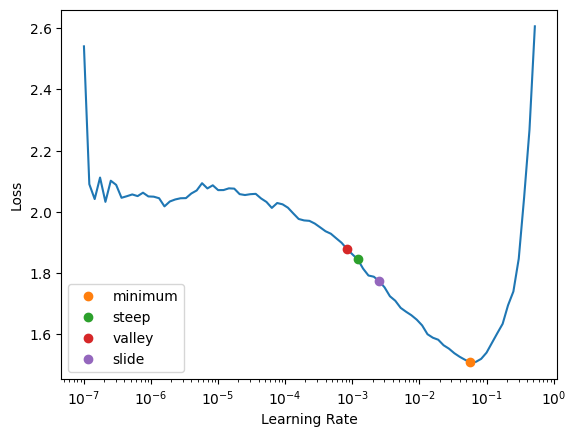

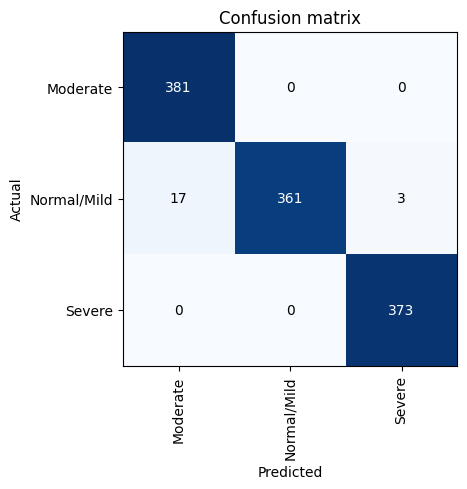

New path creation for column spinal_canal_stenosis_l2_l3.
Preprocessing data (upsampling) for  spinal_canal_stenosis_l2_l3
Length stats of  spinal_canal_stenosis_l2_l3 : 1775   1775   1775
Preparing image paths and labels for current column


100%|██████████| 1000/1000 [04:59<00:00,  3.34it/s]


Saved batch 0 to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l2_l3_image_paths_labels.csv_batch_0.csv


100%|██████████| 1000/1000 [04:48<00:00,  3.47it/s]


Saved batch 1 to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l2_l3_image_paths_labels.csv_batch_1.csv


100%|██████████| 1000/1000 [04:54<00:00,  3.39it/s]


Saved batch 2 to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l2_l3_image_paths_labels.csv_batch_2.csv


100%|██████████| 1000/1000 [04:45<00:00,  3.50it/s]


Saved batch 3 to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l2_l3_image_paths_labels.csv_batch_3.csv


100%|██████████| 1000/1000 [04:39<00:00,  3.58it/s]


Saved batch 4 to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l2_l3_image_paths_labels.csv_batch_4.csv


100%|██████████| 325/325 [01:26<00:00,  3.76it/s]


Saved batch 5 to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l2_l3_image_paths_labels.csv_batch_5.csv
Saved full dataset to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l2_l3_image_paths_labels.csv
Processed and saved data for column: spinal_canal_stenosis_l2_l3 to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l2_l3_image_paths_labels.csv


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.005754399299621582, steep: 7.585775847473997e-07, valley: 0.00363078061491251, slide: 0.0030199517495930195


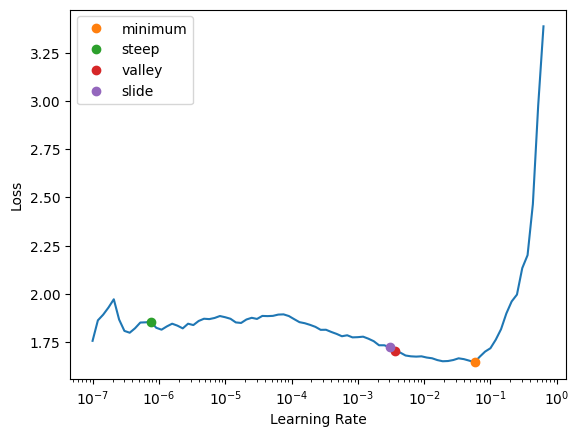

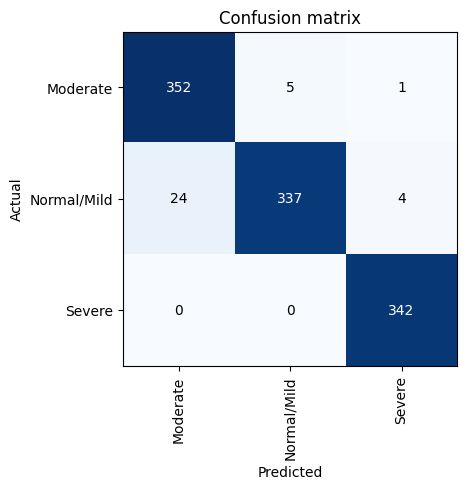

Training model for the column spinal_canal_stenosis_l2_l3 
Length of data training: 5325


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.006918309628963471, steep: 1.2022644114040304e-05, valley: 0.0005754399462603033, slide: 0.004365158267319202


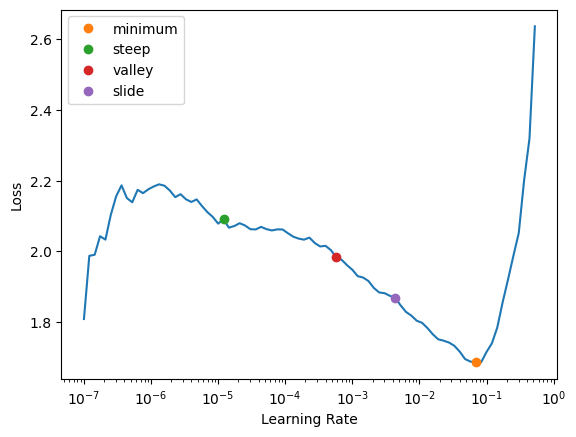

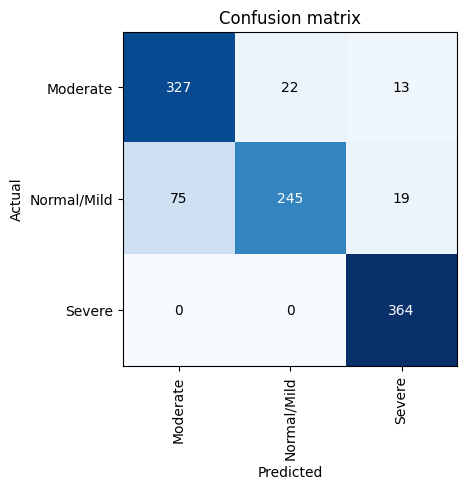

New path creation for column spinal_canal_stenosis_l3_l4.
Preprocessing data (upsampling) for  spinal_canal_stenosis_l3_l4
Length stats of  spinal_canal_stenosis_l3_l4 : 1626   1626   1626
Preparing image paths and labels for current column


100%|██████████| 1000/1000 [04:56<00:00,  3.37it/s]


Saved batch 0 to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l3_l4_image_paths_labels.csv_batch_0.csv


100%|██████████| 1000/1000 [04:51<00:00,  3.43it/s]


Saved batch 1 to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l3_l4_image_paths_labels.csv_batch_1.csv


100%|██████████| 1000/1000 [05:04<00:00,  3.28it/s]


Saved batch 2 to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l3_l4_image_paths_labels.csv_batch_2.csv


100%|██████████| 1000/1000 [05:09<00:00,  3.23it/s]


Saved batch 3 to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l3_l4_image_paths_labels.csv_batch_3.csv


100%|██████████| 878/878 [04:41<00:00,  3.12it/s]


Saved batch 4 to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l3_l4_image_paths_labels.csv_batch_4.csv
Saved full dataset to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l3_l4_image_paths_labels.csv
Processed and saved data for column: spinal_canal_stenosis_l3_l4 to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l3_l4_image_paths_labels.csv


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.006918309628963471, steep: 1.9054607491852948e-06, valley: 0.001737800776027143, slide: 0.004365158267319202


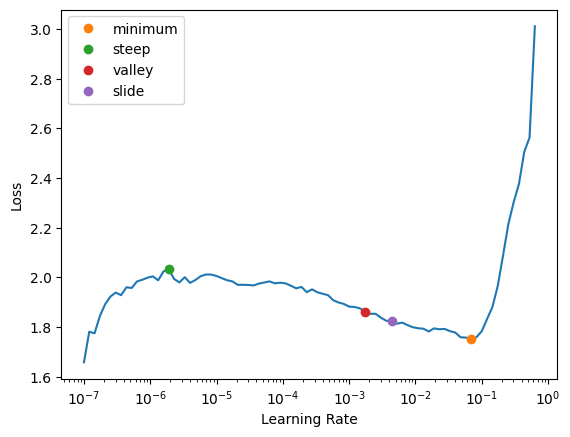

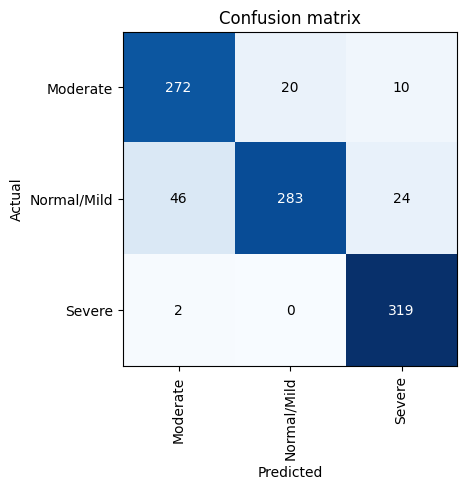

Training model for the column spinal_canal_stenosis_l3_l4 
Length of data training: 4878


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.003981071710586548, steep: 7.585775847473997e-07, valley: 0.0008317637839354575, slide: 0.002511886414140463


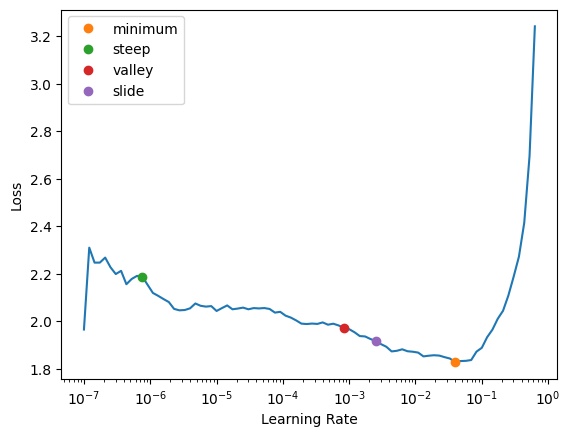

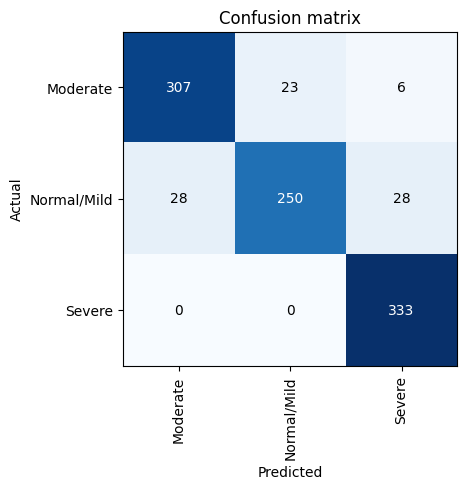

New path creation for column spinal_canal_stenosis_l4_l5.
Preprocessing data (upsampling) for  spinal_canal_stenosis_l4_l5
Length stats of  spinal_canal_stenosis_l4_l5 : 1486   1486   1486
Preparing image paths and labels for current column


100%|██████████| 1000/1000 [04:52<00:00,  3.42it/s]


Saved batch 0 to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l4_l5_image_paths_labels.csv_batch_0.csv


100%|██████████| 1000/1000 [04:45<00:00,  3.50it/s]


Saved batch 1 to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l4_l5_image_paths_labels.csv_batch_1.csv


100%|██████████| 1000/1000 [05:01<00:00,  3.31it/s]


Saved batch 2 to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l4_l5_image_paths_labels.csv_batch_2.csv


100%|██████████| 1000/1000 [05:27<00:00,  3.06it/s]


Saved batch 3 to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l4_l5_image_paths_labels.csv_batch_3.csv


100%|██████████| 458/458 [02:33<00:00,  2.98it/s]


Saved batch 4 to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l4_l5_image_paths_labels.csv_batch_4.csv
Saved full dataset to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l4_l5_image_paths_labels.csv
Processed and saved data for column: spinal_canal_stenosis_l4_l5 to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l4_l5_image_paths_labels.csv


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.001096478197723627, steep: 4.786300905834651e-06, valley: 0.0005754399462603033, slide: 0.004365158267319202


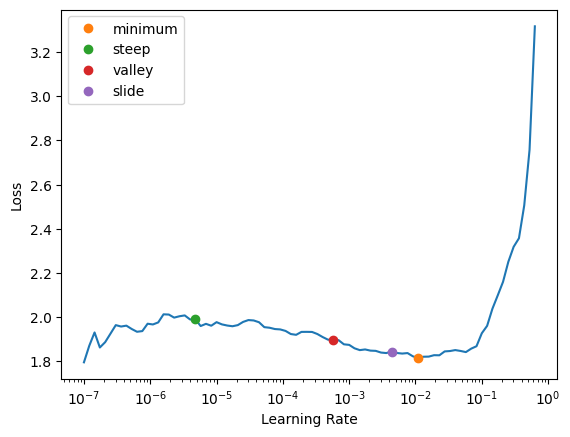

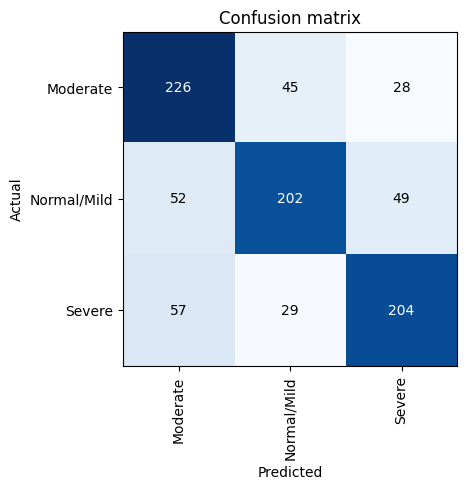

Training model for the column spinal_canal_stenosis_l4_l5 
Length of data training: 4458


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.00043651582673192023, steep: 0.00363078061491251, valley: 0.001737800776027143, slide: 0.0030199517495930195


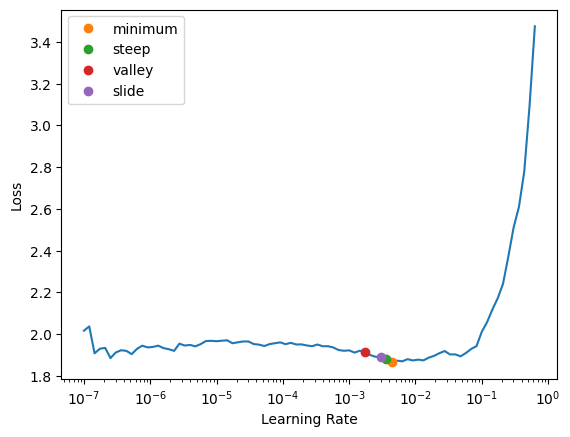

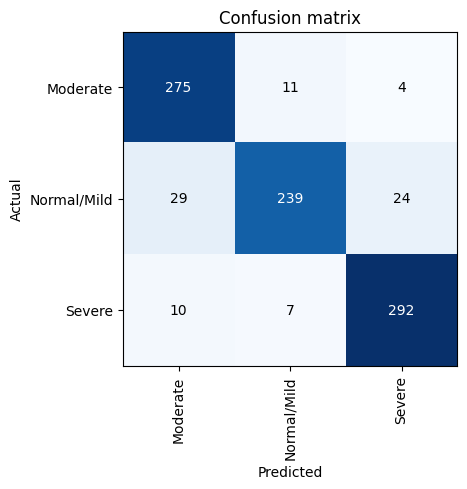

New path creation for column spinal_canal_stenosis_l5_s1.
Preprocessing data (upsampling) for  spinal_canal_stenosis_l5_s1
Length stats of  spinal_canal_stenosis_l5_s1 : 1909   1909   1909
Preparing image paths and labels for current column


100%|██████████| 1000/1000 [04:59<00:00,  3.34it/s]


Saved batch 0 to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l5_s1_image_paths_labels.csv_batch_0.csv


100%|██████████| 1000/1000 [04:50<00:00,  3.44it/s]


Saved batch 1 to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l5_s1_image_paths_labels.csv_batch_1.csv


100%|██████████| 1000/1000 [04:41<00:00,  3.55it/s]


Saved batch 2 to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l5_s1_image_paths_labels.csv_batch_2.csv


100%|██████████| 1000/1000 [04:48<00:00,  3.46it/s]


Saved batch 3 to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l5_s1_image_paths_labels.csv_batch_3.csv


100%|██████████| 1000/1000 [05:00<00:00,  3.32it/s]


Saved batch 4 to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l5_s1_image_paths_labels.csv_batch_4.csv


100%|██████████| 727/727 [03:37<00:00,  3.35it/s]


Saved batch 5 to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l5_s1_image_paths_labels.csv_batch_5.csv
Saved full dataset to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l5_s1_image_paths_labels.csv
Processed and saved data for column: spinal_canal_stenosis_l5_s1 to /kaggle/working/CurrentLabels/spinal_canal_stenosis_l5_s1_image_paths_labels.csv


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.006918309628963471, steep: 7.585775847473997e-07, valley: 0.0012022644514217973, slide: 0.001737800776027143


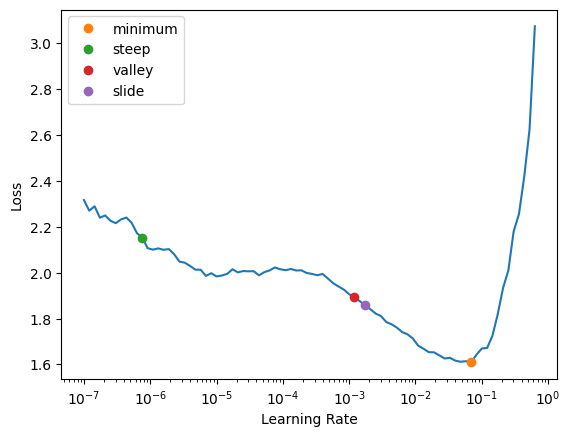

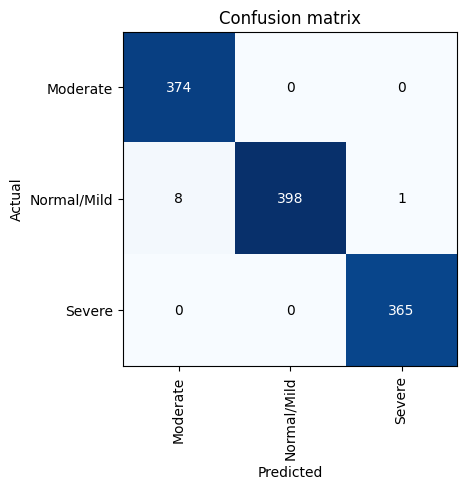

Training model for the column spinal_canal_stenosis_l5_s1 
Length of data training: 5727


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.003981071710586548, steep: 0.0010000000474974513, valley: 0.0010000000474974513, slide: 0.002511886414140463


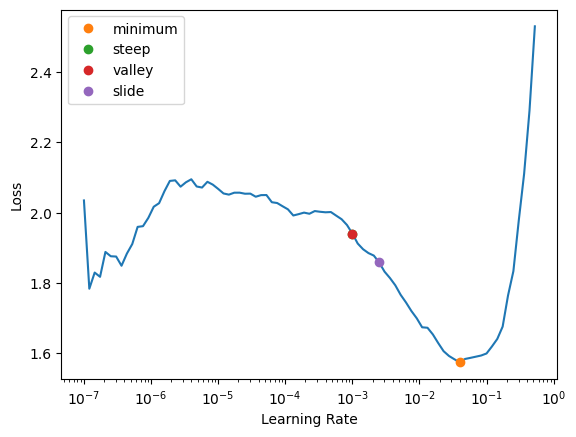

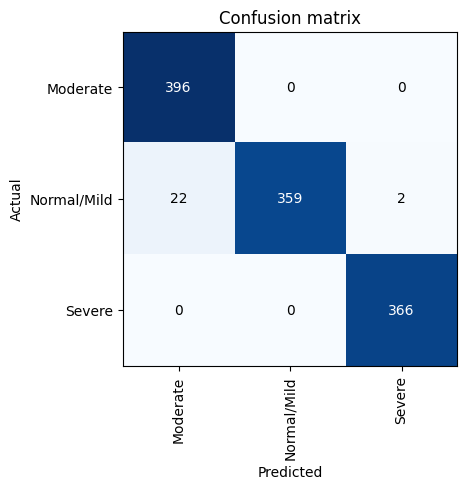

New path creation for column left_neural_foraminal_narrowing_l1_l2.
Preprocessing data (upsampling) for  left_neural_foraminal_narrowing_l1_l2
Length stats of  left_neural_foraminal_narrowing_l1_l2 : 1915   1915   1915
Preparing image paths and labels for current column


100%|██████████| 1000/1000 [05:02<00:00,  3.31it/s]


Saved batch 0 to /kaggle/working/CurrentLabels/left_neural_foraminal_narrowing_l1_l2_image_paths_labels.csv_batch_0.csv


100%|██████████| 1000/1000 [04:52<00:00,  3.42it/s]


Saved batch 1 to /kaggle/working/CurrentLabels/left_neural_foraminal_narrowing_l1_l2_image_paths_labels.csv_batch_1.csv


100%|██████████| 1000/1000 [05:03<00:00,  3.29it/s]


Saved batch 2 to /kaggle/working/CurrentLabels/left_neural_foraminal_narrowing_l1_l2_image_paths_labels.csv_batch_2.csv


100%|██████████| 1000/1000 [04:56<00:00,  3.37it/s]


Saved batch 3 to /kaggle/working/CurrentLabels/left_neural_foraminal_narrowing_l1_l2_image_paths_labels.csv_batch_3.csv


100%|██████████| 1000/1000 [03:48<00:00,  4.38it/s]


Saved batch 4 to /kaggle/working/CurrentLabels/left_neural_foraminal_narrowing_l1_l2_image_paths_labels.csv_batch_4.csv


100%|██████████| 745/745 [02:50<00:00,  4.36it/s]


Saved batch 5 to /kaggle/working/CurrentLabels/left_neural_foraminal_narrowing_l1_l2_image_paths_labels.csv_batch_5.csv
Saved full dataset to /kaggle/working/CurrentLabels/left_neural_foraminal_narrowing_l1_l2_image_paths_labels.csv
Processed and saved data for column: left_neural_foraminal_narrowing_l1_l2 to /kaggle/working/CurrentLabels/left_neural_foraminal_narrowing_l1_l2_image_paths_labels.csv


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.00831763744354248, steep: 0.0006918309954926372, valley: 0.0012022644514217973, slide: 0.0006918309954926372


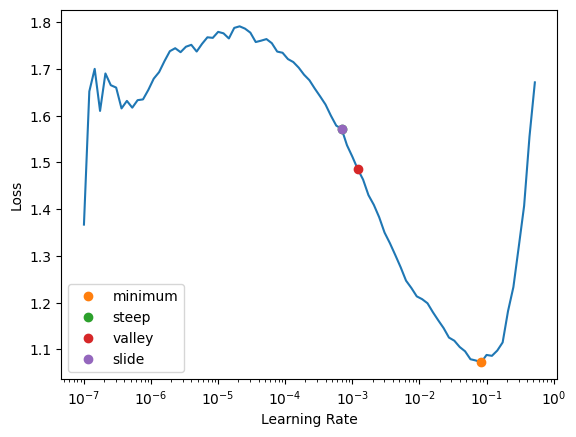

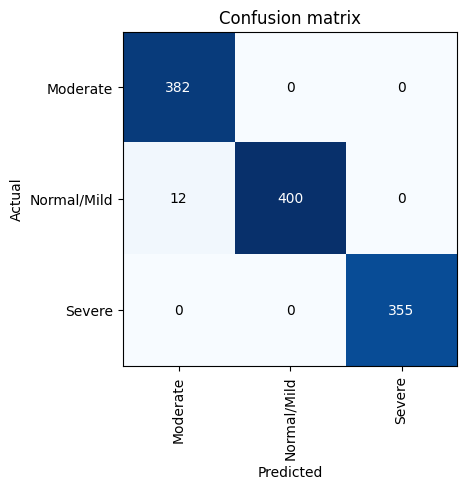

Training model for the column left_neural_foraminal_narrowing_l1_l2 
Length of data training: 5745


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.00831763744354248, steep: 0.0010000000474974513, valley: 0.0008317637839354575, slide: 0.0005754399462603033


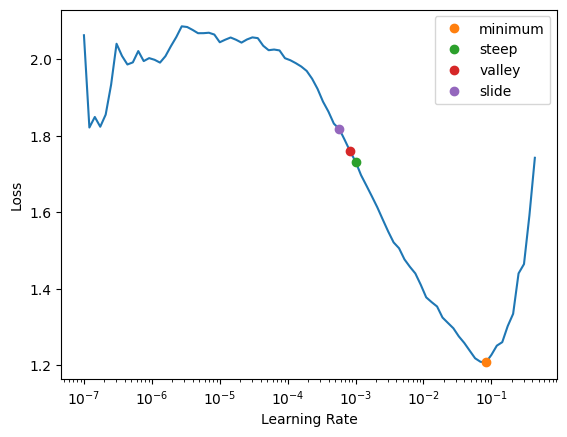

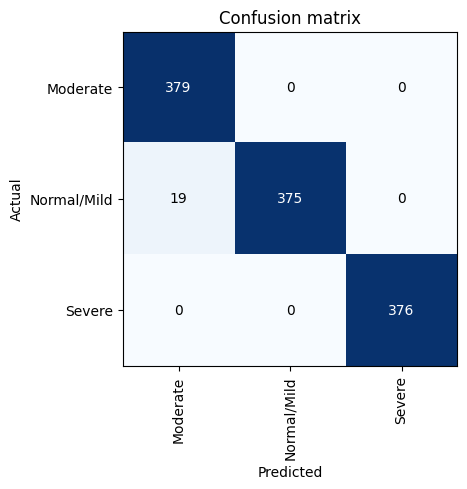

New path creation for column left_neural_foraminal_narrowing_l2_l3.
Preprocessing data (upsampling) for  left_neural_foraminal_narrowing_l2_l3
Length stats of  left_neural_foraminal_narrowing_l2_l3 : 1798   1798   1798
Preparing image paths and labels for current column


100%|██████████| 1000/1000 [05:01<00:00,  3.31it/s]


Saved batch 0 to /kaggle/working/CurrentLabels/left_neural_foraminal_narrowing_l2_l3_image_paths_labels.csv_batch_0.csv


100%|██████████| 1000/1000 [04:50<00:00,  3.44it/s]


Saved batch 1 to /kaggle/working/CurrentLabels/left_neural_foraminal_narrowing_l2_l3_image_paths_labels.csv_batch_1.csv


100%|██████████| 1000/1000 [04:54<00:00,  3.39it/s]


Saved batch 2 to /kaggle/working/CurrentLabels/left_neural_foraminal_narrowing_l2_l3_image_paths_labels.csv_batch_2.csv


100%|██████████| 1000/1000 [05:07<00:00,  3.26it/s]


Saved batch 3 to /kaggle/working/CurrentLabels/left_neural_foraminal_narrowing_l2_l3_image_paths_labels.csv_batch_3.csv


100%|██████████| 1000/1000 [05:19<00:00,  3.13it/s]


Saved batch 4 to /kaggle/working/CurrentLabels/left_neural_foraminal_narrowing_l2_l3_image_paths_labels.csv_batch_4.csv


100%|██████████| 394/394 [02:07<00:00,  3.08it/s]


Saved batch 5 to /kaggle/working/CurrentLabels/left_neural_foraminal_narrowing_l2_l3_image_paths_labels.csv_batch_5.csv
Saved full dataset to /kaggle/working/CurrentLabels/left_neural_foraminal_narrowing_l2_l3_image_paths_labels.csv
Processed and saved data for column: left_neural_foraminal_narrowing_l2_l3 to /kaggle/working/CurrentLabels/left_neural_foraminal_narrowing_l2_l3_image_paths_labels.csv


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.00831763744354248, steep: 0.0063095735386013985, valley: 0.0006918309954926372, slide: 0.004365158267319202


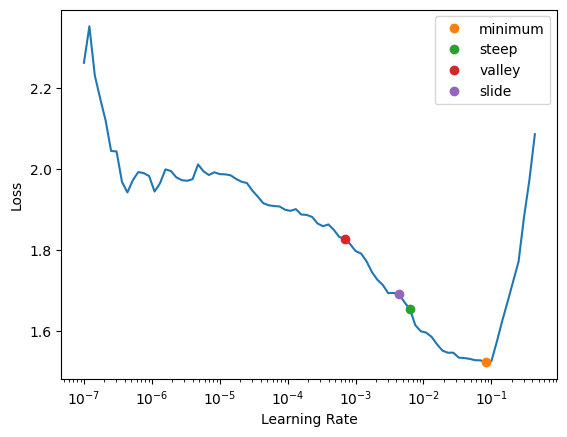

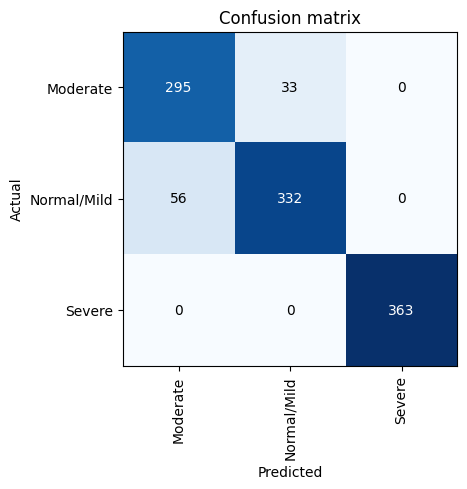

Training model for the column left_neural_foraminal_narrowing_l2_l3 
Length of data training: 5394


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.006918309628963471, steep: 6.309573450380412e-07, valley: 0.001737800776027143, slide: 0.0020892962347716093


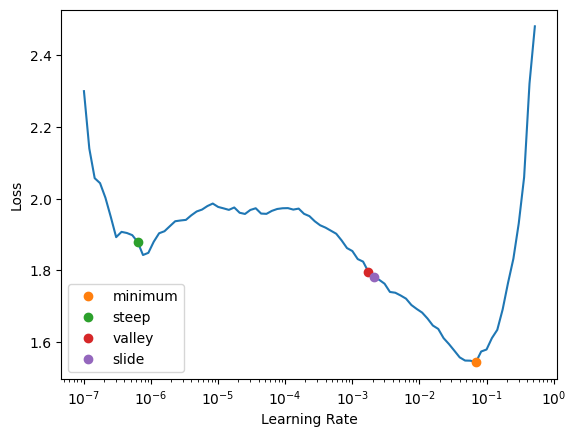

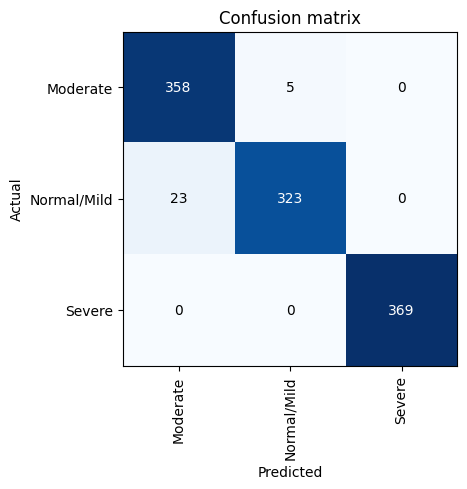

New path creation for column left_neural_foraminal_narrowing_l3_l4.
Preprocessing data (upsampling) for  left_neural_foraminal_narrowing_l3_l4
Length stats of  left_neural_foraminal_narrowing_l3_l4 : 1529   1529   1529
Preparing image paths and labels for current column


100%|██████████| 1000/1000 [04:58<00:00,  3.35it/s]


Saved batch 0 to /kaggle/working/CurrentLabels/left_neural_foraminal_narrowing_l3_l4_image_paths_labels.csv_batch_0.csv


100%|██████████| 1000/1000 [04:53<00:00,  3.40it/s]


Saved batch 1 to /kaggle/working/CurrentLabels/left_neural_foraminal_narrowing_l3_l4_image_paths_labels.csv_batch_1.csv


100%|██████████| 1000/1000 [04:54<00:00,  3.40it/s]


Saved batch 2 to /kaggle/working/CurrentLabels/left_neural_foraminal_narrowing_l3_l4_image_paths_labels.csv_batch_2.csv


100%|██████████| 1000/1000 [05:09<00:00,  3.23it/s]


Saved batch 3 to /kaggle/working/CurrentLabels/left_neural_foraminal_narrowing_l3_l4_image_paths_labels.csv_batch_3.csv


100%|██████████| 587/587 [02:59<00:00,  3.26it/s]


Saved batch 4 to /kaggle/working/CurrentLabels/left_neural_foraminal_narrowing_l3_l4_image_paths_labels.csv_batch_4.csv
Saved full dataset to /kaggle/working/CurrentLabels/left_neural_foraminal_narrowing_l3_l4_image_paths_labels.csv
Processed and saved data for column: left_neural_foraminal_narrowing_l3_l4 to /kaggle/working/CurrentLabels/left_neural_foraminal_narrowing_l3_l4_image_paths_labels.csv


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.004786301031708717, steep: 6.918309736647643e-06, valley: 0.0030199517495930195, slide: 0.00363078061491251


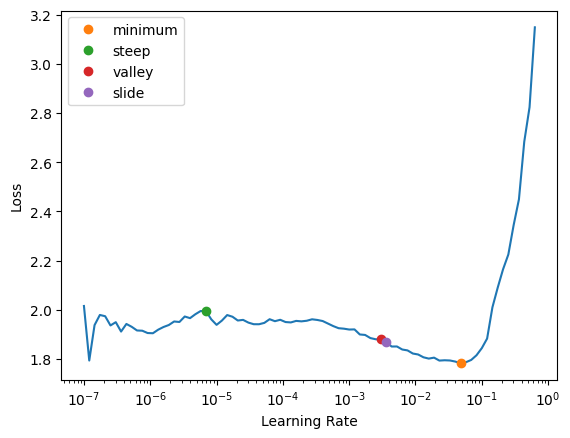

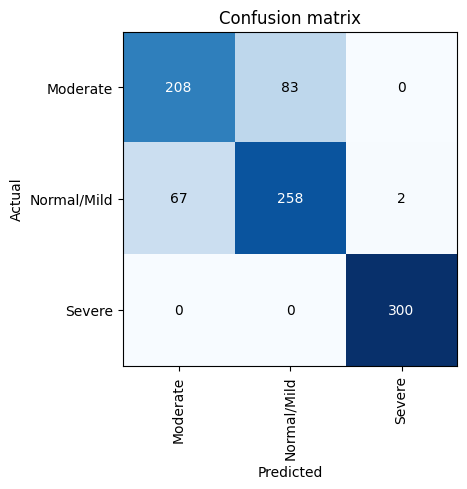

Training model for the column left_neural_foraminal_narrowing_l3_l4 
Length of data training: 4587


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.005754399299621582, steep: 9.12010818865383e-07, valley: 0.0020892962347716093, slide: 0.00363078061491251


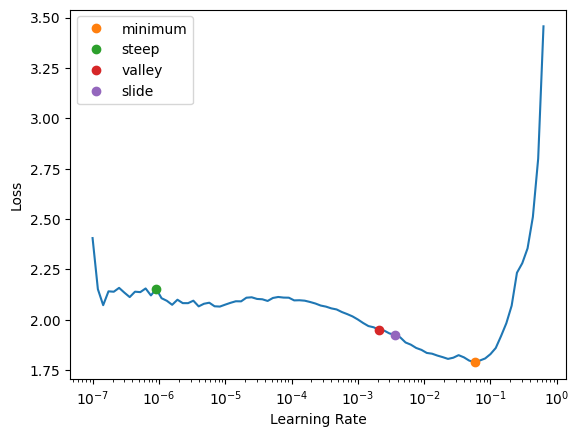

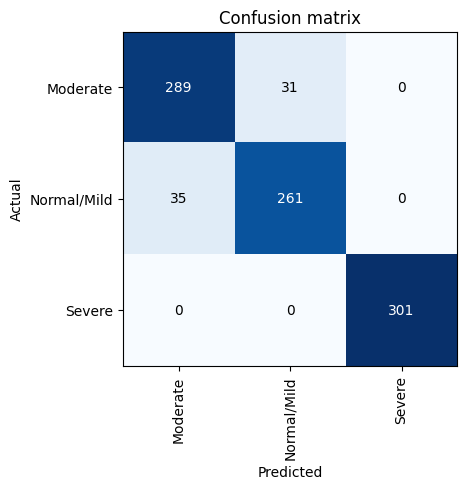

New path creation for column left_neural_foraminal_narrowing_l4_l5.
Preprocessing data (upsampling) for  left_neural_foraminal_narrowing_l4_l5
Length stats of  left_neural_foraminal_narrowing_l4_l5 : 1210   1210   1210
Preparing image paths and labels for current column


100%|██████████| 1000/1000 [04:57<00:00,  3.36it/s]


Saved batch 0 to /kaggle/working/CurrentLabels/left_neural_foraminal_narrowing_l4_l5_image_paths_labels.csv_batch_0.csv


100%|██████████| 1000/1000 [04:51<00:00,  3.43it/s]


Saved batch 1 to /kaggle/working/CurrentLabels/left_neural_foraminal_narrowing_l4_l5_image_paths_labels.csv_batch_1.csv


100%|██████████| 1000/1000 [05:09<00:00,  3.23it/s]


Saved batch 2 to /kaggle/working/CurrentLabels/left_neural_foraminal_narrowing_l4_l5_image_paths_labels.csv_batch_2.csv


100%|██████████| 630/630 [03:13<00:00,  3.26it/s]


Saved batch 3 to /kaggle/working/CurrentLabels/left_neural_foraminal_narrowing_l4_l5_image_paths_labels.csv_batch_3.csv
Saved full dataset to /kaggle/working/CurrentLabels/left_neural_foraminal_narrowing_l4_l5_image_paths_labels.csv
Processed and saved data for column: left_neural_foraminal_narrowing_l4_l5 to /kaggle/working/CurrentLabels/left_neural_foraminal_narrowing_l4_l5_image_paths_labels.csv


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.0006309573538601399, steep: 0.0005754399462603033, valley: 0.0006918309954926372, slide: 0.0020892962347716093


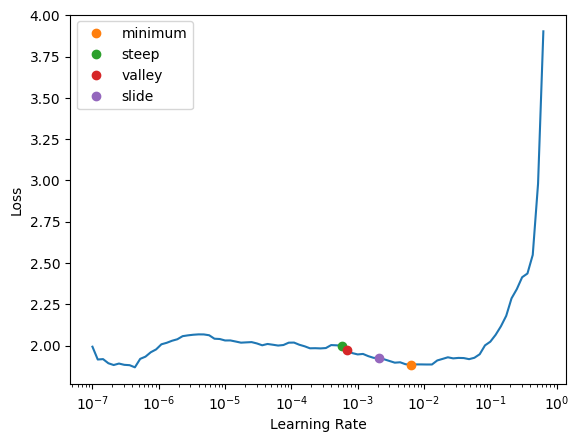

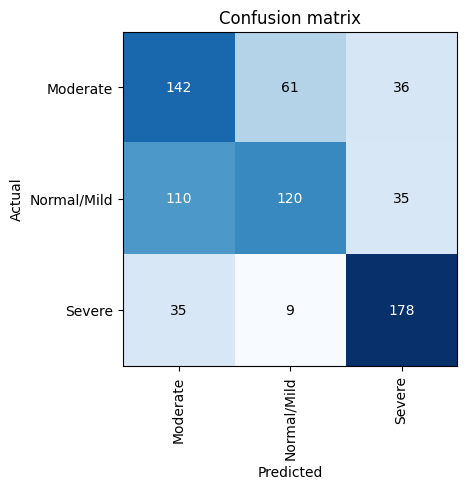

Training model for the column left_neural_foraminal_narrowing_l4_l5 
Length of data training: 3630


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.0013182567432522773, steep: 7.585775847473997e-07, valley: 0.0006918309954926372, slide: 0.0014454397605732083


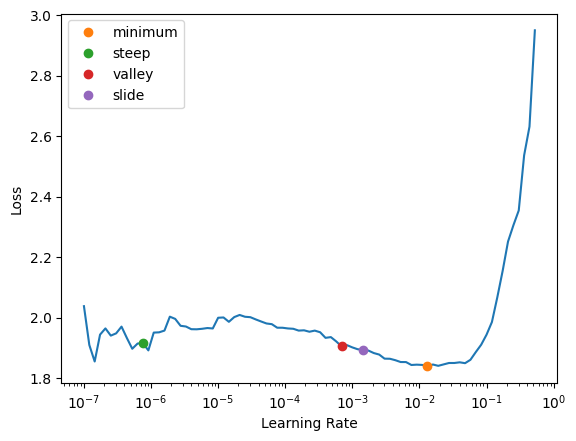

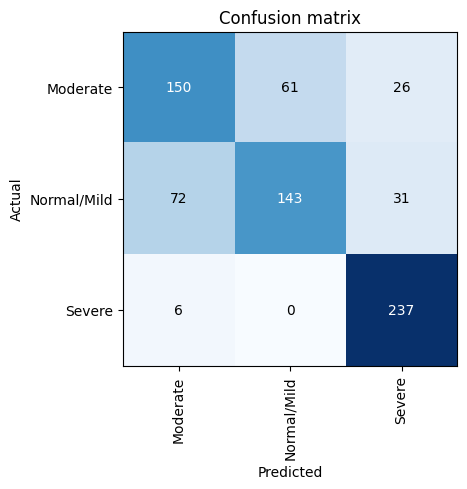

New path creation for column left_neural_foraminal_narrowing_l5_s1.
Preprocessing data (upsampling) for  left_neural_foraminal_narrowing_l5_s1
Length stats of  left_neural_foraminal_narrowing_l5_s1 : 1253   1253   1253
Preparing image paths and labels for current column


100%|██████████| 1000/1000 [05:02<00:00,  3.30it/s]


Saved batch 0 to /kaggle/working/CurrentLabels/left_neural_foraminal_narrowing_l5_s1_image_paths_labels.csv_batch_0.csv


100%|██████████| 1000/1000 [04:55<00:00,  3.38it/s]


Saved batch 1 to /kaggle/working/CurrentLabels/left_neural_foraminal_narrowing_l5_s1_image_paths_labels.csv_batch_1.csv


100%|██████████| 1000/1000 [05:03<00:00,  3.29it/s]


Saved batch 2 to /kaggle/working/CurrentLabels/left_neural_foraminal_narrowing_l5_s1_image_paths_labels.csv_batch_2.csv


100%|██████████| 759/759 [03:42<00:00,  3.41it/s]


Saved batch 3 to /kaggle/working/CurrentLabels/left_neural_foraminal_narrowing_l5_s1_image_paths_labels.csv_batch_3.csv
Saved full dataset to /kaggle/working/CurrentLabels/left_neural_foraminal_narrowing_l5_s1_image_paths_labels.csv
Processed and saved data for column: left_neural_foraminal_narrowing_l5_s1 to /kaggle/working/CurrentLabels/left_neural_foraminal_narrowing_l5_s1_image_paths_labels.csv


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.0013182567432522773, steep: 7.585775847473997e-07, valley: 0.0010000000474974513, slide: 0.004365158267319202


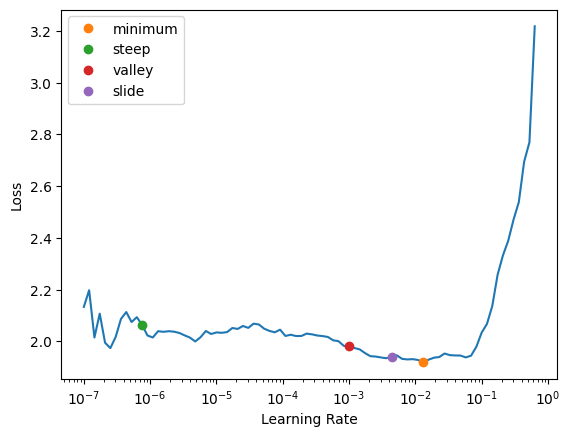

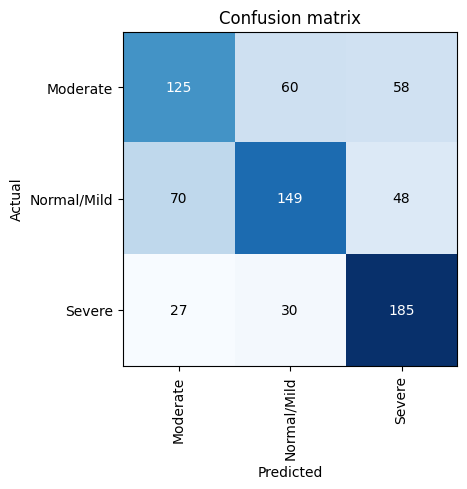

Training model for the column left_neural_foraminal_narrowing_l5_s1 
Length of data training: 3759


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.0005248074419796466, steep: 1.0964781722577754e-06, valley: 0.0004786300996784121, slide: 0.00363078061491251


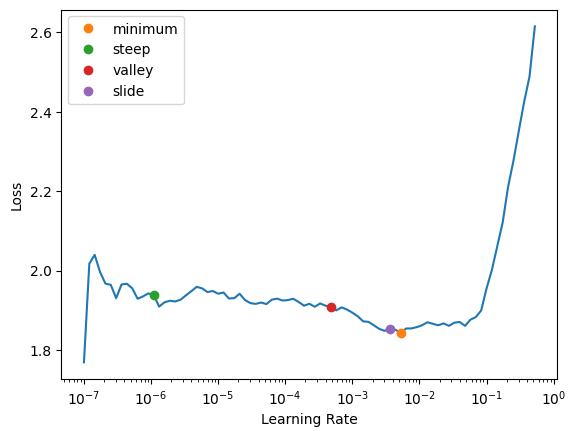

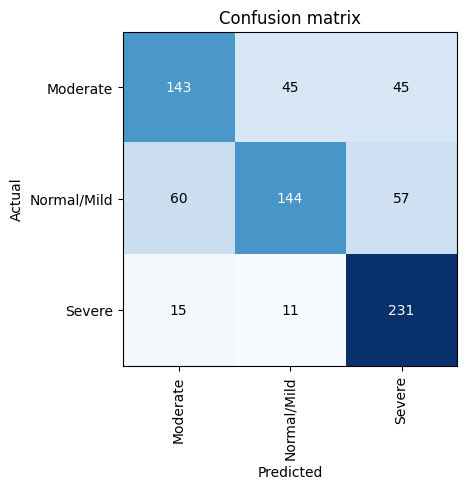

New path creation for column right_neural_foraminal_narrowing_l1_l2.
Preprocessing data (upsampling) for  right_neural_foraminal_narrowing_l1_l2
Length stats of  right_neural_foraminal_narrowing_l1_l2 : 1897   1897   1897
Preparing image paths and labels for current column


100%|██████████| 1000/1000 [05:01<00:00,  3.31it/s]


Saved batch 0 to /kaggle/working/CurrentLabels/right_neural_foraminal_narrowing_l1_l2_image_paths_labels.csv_batch_0.csv


100%|██████████| 1000/1000 [04:57<00:00,  3.36it/s]


Saved batch 1 to /kaggle/working/CurrentLabels/right_neural_foraminal_narrowing_l1_l2_image_paths_labels.csv_batch_1.csv


100%|██████████| 1000/1000 [05:24<00:00,  3.08it/s]


Saved batch 2 to /kaggle/working/CurrentLabels/right_neural_foraminal_narrowing_l1_l2_image_paths_labels.csv_batch_2.csv


100%|██████████| 1000/1000 [05:29<00:00,  3.03it/s]


Saved batch 3 to /kaggle/working/CurrentLabels/right_neural_foraminal_narrowing_l1_l2_image_paths_labels.csv_batch_3.csv


100%|██████████| 1000/1000 [04:57<00:00,  3.36it/s]


Saved batch 4 to /kaggle/working/CurrentLabels/right_neural_foraminal_narrowing_l1_l2_image_paths_labels.csv_batch_4.csv


100%|██████████| 691/691 [03:26<00:00,  3.34it/s]


Saved batch 5 to /kaggle/working/CurrentLabels/right_neural_foraminal_narrowing_l1_l2_image_paths_labels.csv_batch_5.csv
Saved full dataset to /kaggle/working/CurrentLabels/right_neural_foraminal_narrowing_l1_l2_image_paths_labels.csv
Processed and saved data for column: right_neural_foraminal_narrowing_l1_l2 to /kaggle/working/CurrentLabels/right_neural_foraminal_narrowing_l1_l2_image_paths_labels.csv


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.003981071710586548, steep: 1.3182567499825382e-06, valley: 0.0005754399462603033, slide: 0.0012022644514217973


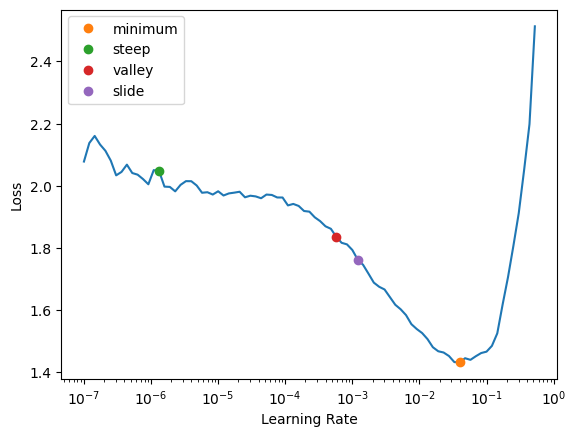

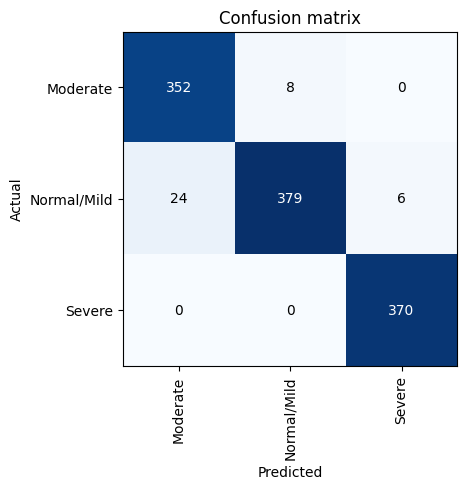

Training model for the column right_neural_foraminal_narrowing_l1_l2 
Length of data training: 5691


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.003981071710586548, steep: 0.002511886414140463, valley: 0.001737800776027143, slide: 0.0020892962347716093


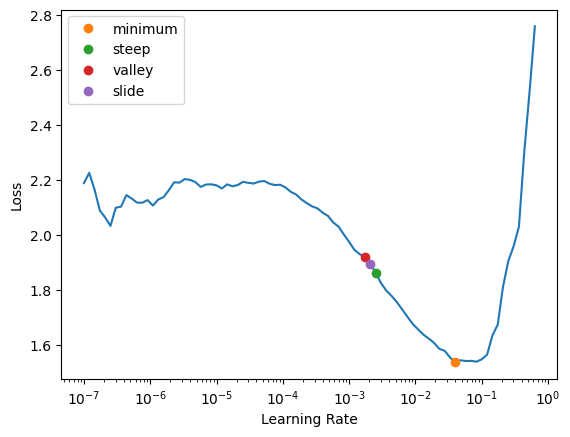

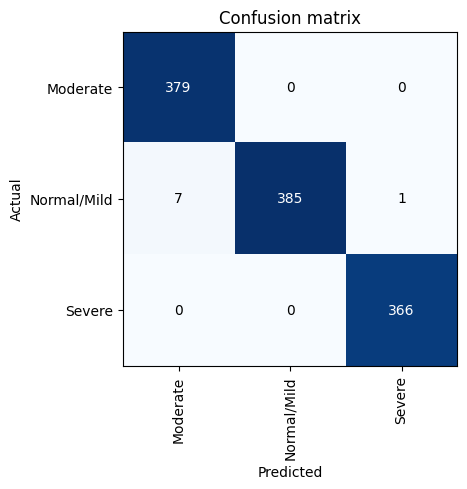

New path creation for column right_neural_foraminal_narrowing_l2_l3.
Preprocessing data (upsampling) for  right_neural_foraminal_narrowing_l2_l3
Length stats of  right_neural_foraminal_narrowing_l2_l3 : 1799   1799   1799
Preparing image paths and labels for current column


100%|██████████| 1000/1000 [05:00<00:00,  3.33it/s]


Saved batch 0 to /kaggle/working/CurrentLabels/right_neural_foraminal_narrowing_l2_l3_image_paths_labels.csv_batch_0.csv


100%|██████████| 1000/1000 [04:54<00:00,  3.40it/s]


Saved batch 1 to /kaggle/working/CurrentLabels/right_neural_foraminal_narrowing_l2_l3_image_paths_labels.csv_batch_1.csv


100%|██████████| 1000/1000 [05:20<00:00,  3.12it/s]


Saved batch 2 to /kaggle/working/CurrentLabels/right_neural_foraminal_narrowing_l2_l3_image_paths_labels.csv_batch_2.csv


100%|██████████| 1000/1000 [05:20<00:00,  3.12it/s]


Saved batch 3 to /kaggle/working/CurrentLabels/right_neural_foraminal_narrowing_l2_l3_image_paths_labels.csv_batch_3.csv


100%|██████████| 1000/1000 [05:50<00:00,  2.85it/s]


Saved batch 4 to /kaggle/working/CurrentLabels/right_neural_foraminal_narrowing_l2_l3_image_paths_labels.csv_batch_4.csv


100%|██████████| 397/397 [02:19<00:00,  2.85it/s]


Saved batch 5 to /kaggle/working/CurrentLabels/right_neural_foraminal_narrowing_l2_l3_image_paths_labels.csv_batch_5.csv
Saved full dataset to /kaggle/working/CurrentLabels/right_neural_foraminal_narrowing_l2_l3_image_paths_labels.csv
Processed and saved data for column: right_neural_foraminal_narrowing_l2_l3 to /kaggle/working/CurrentLabels/right_neural_foraminal_narrowing_l2_l3_image_paths_labels.csv


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.006918309628963471, steep: 0.0002290867705596611, valley: 0.0006918309954926372, slide: 0.0030199517495930195


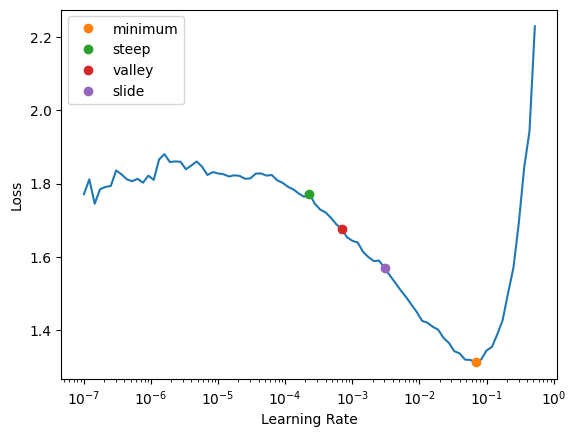

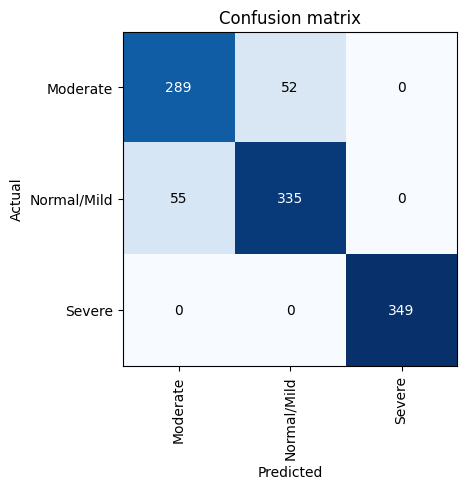

Training model for the column right_neural_foraminal_narrowing_l2_l3 
Length of data training: 5397


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.00831763744354248, steep: 0.0063095735386013985, valley: 0.0008317637839354575, slide: 0.0030199517495930195


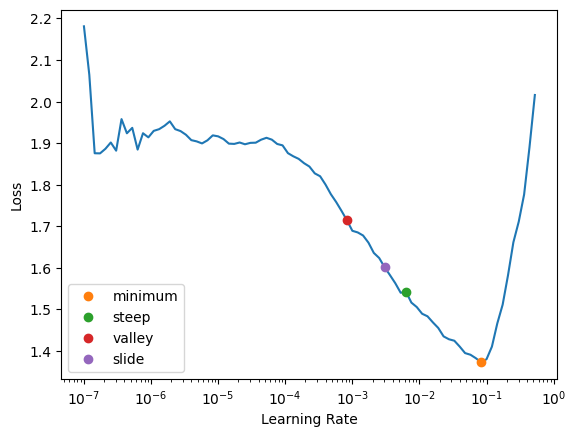

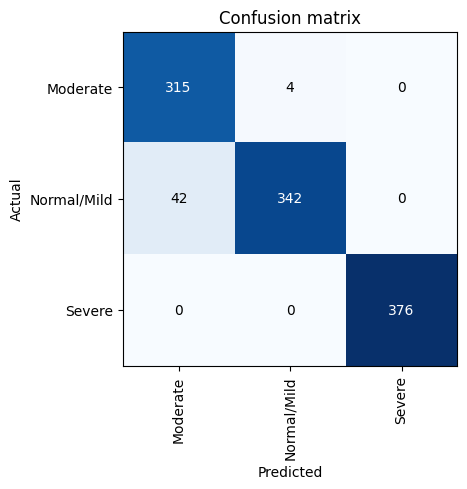

New path creation for column right_neural_foraminal_narrowing_l3_l4.
Preprocessing data (upsampling) for  right_neural_foraminal_narrowing_l3_l4
Length stats of  right_neural_foraminal_narrowing_l3_l4 : 1517   1517   1517
Preparing image paths and labels for current column


100%|██████████| 1000/1000 [04:57<00:00,  3.36it/s]


Saved batch 0 to /kaggle/working/CurrentLabels/right_neural_foraminal_narrowing_l3_l4_image_paths_labels.csv_batch_0.csv


100%|██████████| 1000/1000 [04:55<00:00,  3.38it/s]


Saved batch 1 to /kaggle/working/CurrentLabels/right_neural_foraminal_narrowing_l3_l4_image_paths_labels.csv_batch_1.csv


100%|██████████| 1000/1000 [05:08<00:00,  3.24it/s]


Saved batch 2 to /kaggle/working/CurrentLabels/right_neural_foraminal_narrowing_l3_l4_image_paths_labels.csv_batch_2.csv


100%|██████████| 1000/1000 [05:08<00:00,  3.24it/s]


Saved batch 3 to /kaggle/working/CurrentLabels/right_neural_foraminal_narrowing_l3_l4_image_paths_labels.csv_batch_3.csv


100%|██████████| 551/551 [02:50<00:00,  3.23it/s]


Saved batch 4 to /kaggle/working/CurrentLabels/right_neural_foraminal_narrowing_l3_l4_image_paths_labels.csv_batch_4.csv
Saved full dataset to /kaggle/working/CurrentLabels/right_neural_foraminal_narrowing_l3_l4_image_paths_labels.csv
Processed and saved data for column: right_neural_foraminal_narrowing_l3_l4 to /kaggle/working/CurrentLabels/right_neural_foraminal_narrowing_l3_l4_image_paths_labels.csv


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.004786301031708717, steep: 0.004365158267319202, valley: 0.0012022644514217973, slide: 0.0020892962347716093


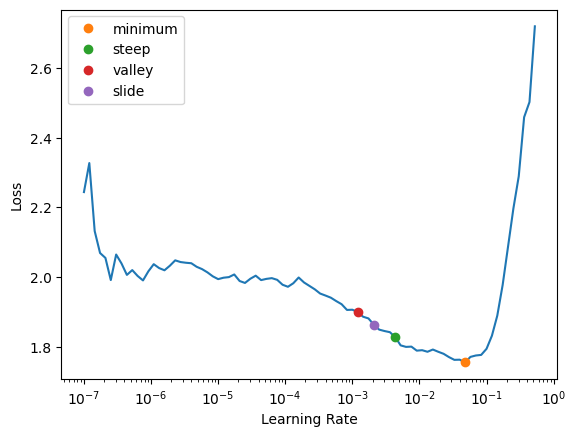

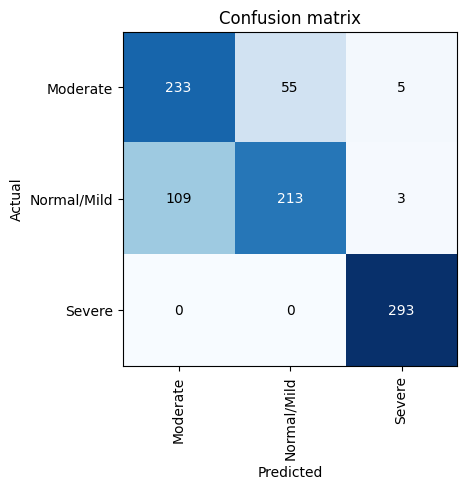

Training model for the column right_neural_foraminal_narrowing_l3_l4 
Length of data training: 4551


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.003981071710586548, steep: 7.585775847473997e-07, valley: 0.0014454397605732083, slide: 0.0014454397605732083


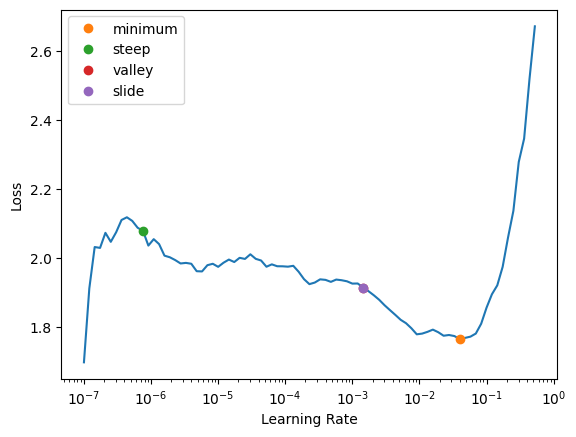

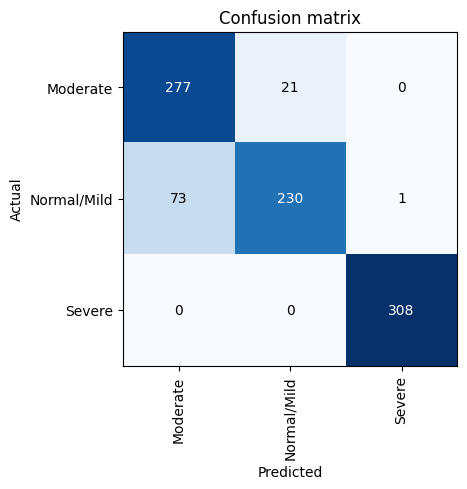

New path creation for column right_neural_foraminal_narrowing_l4_l5.
Preprocessing data (upsampling) for  right_neural_foraminal_narrowing_l4_l5
Length stats of  right_neural_foraminal_narrowing_l4_l5 : 1212   1212   1212
Preparing image paths and labels for current column


100%|██████████| 1000/1000 [04:49<00:00,  3.45it/s]


Saved batch 0 to /kaggle/working/CurrentLabels/right_neural_foraminal_narrowing_l4_l5_image_paths_labels.csv_batch_0.csv


100%|██████████| 1000/1000 [05:09<00:00,  3.23it/s]


Saved batch 1 to /kaggle/working/CurrentLabels/right_neural_foraminal_narrowing_l4_l5_image_paths_labels.csv_batch_1.csv


100%|██████████| 1000/1000 [05:19<00:00,  3.13it/s]


Saved batch 2 to /kaggle/working/CurrentLabels/right_neural_foraminal_narrowing_l4_l5_image_paths_labels.csv_batch_2.csv


100%|██████████| 636/636 [03:24<00:00,  3.11it/s]


Saved batch 3 to /kaggle/working/CurrentLabels/right_neural_foraminal_narrowing_l4_l5_image_paths_labels.csv_batch_3.csv
Saved full dataset to /kaggle/working/CurrentLabels/right_neural_foraminal_narrowing_l4_l5_image_paths_labels.csv
Processed and saved data for column: right_neural_foraminal_narrowing_l4_l5 to /kaggle/working/CurrentLabels/right_neural_foraminal_narrowing_l4_l5_image_paths_labels.csv


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.002754228748381138, steep: 7.585775847473997e-07, valley: 0.001737800776027143, slide: 0.0014454397605732083


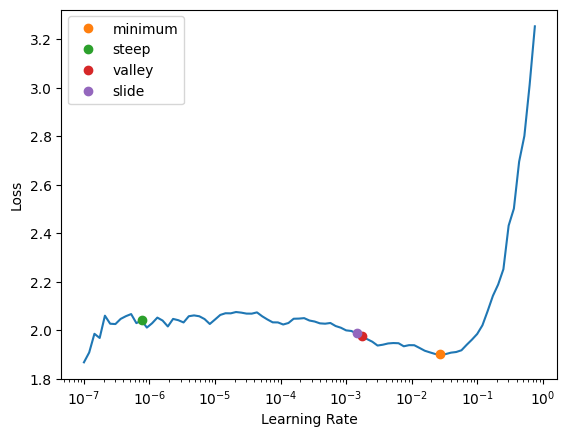

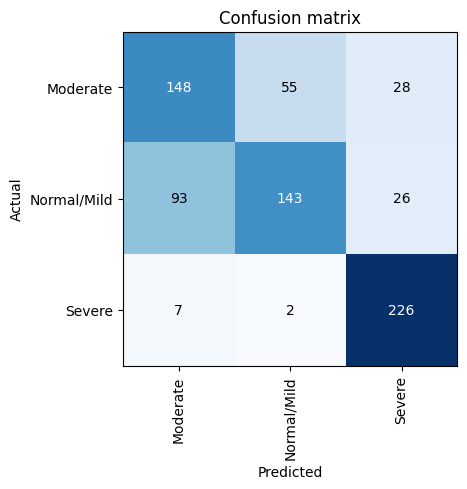

Training model for the column right_neural_foraminal_narrowing_l4_l5 
Length of data training: 3636


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.004786301031708717, steep: 6.918309736647643e-06, valley: 0.0020892962347716093, slide: 0.00363078061491251


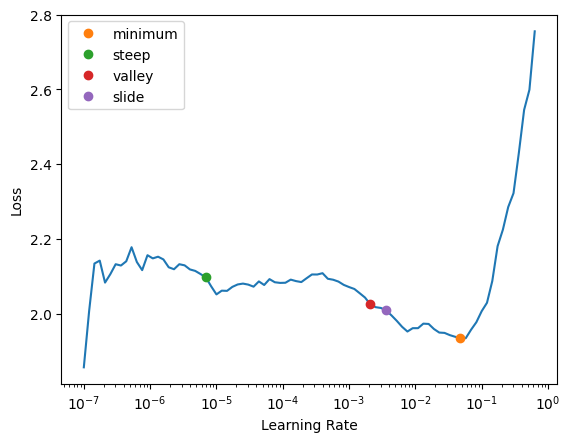

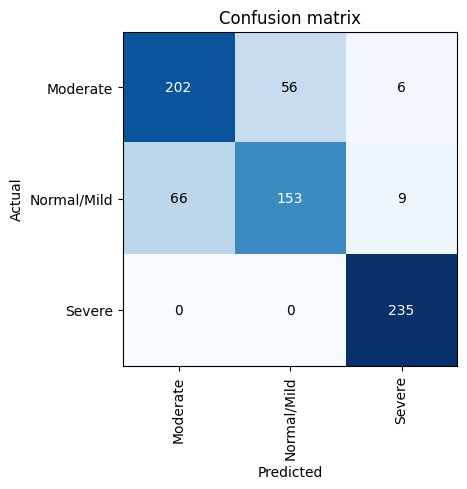

New path creation for column right_neural_foraminal_narrowing_l5_s1.
Preprocessing data (upsampling) for  right_neural_foraminal_narrowing_l5_s1
Length stats of  right_neural_foraminal_narrowing_l5_s1 : 1286   1286   1286
Preparing image paths and labels for current column


100%|██████████| 1000/1000 [05:00<00:00,  3.33it/s]


Saved batch 0 to /kaggle/working/CurrentLabels/right_neural_foraminal_narrowing_l5_s1_image_paths_labels.csv_batch_0.csv


100%|██████████| 1000/1000 [04:57<00:00,  3.36it/s]


Saved batch 1 to /kaggle/working/CurrentLabels/right_neural_foraminal_narrowing_l5_s1_image_paths_labels.csv_batch_1.csv


100%|██████████| 1000/1000 [04:58<00:00,  3.36it/s]


Saved batch 2 to /kaggle/working/CurrentLabels/right_neural_foraminal_narrowing_l5_s1_image_paths_labels.csv_batch_2.csv


100%|██████████| 858/858 [04:17<00:00,  3.34it/s]


Saved batch 3 to /kaggle/working/CurrentLabels/right_neural_foraminal_narrowing_l5_s1_image_paths_labels.csv_batch_3.csv
Saved full dataset to /kaggle/working/CurrentLabels/right_neural_foraminal_narrowing_l5_s1_image_paths_labels.csv
Processed and saved data for column: right_neural_foraminal_narrowing_l5_s1 to /kaggle/working/CurrentLabels/right_neural_foraminal_narrowing_l5_s1_image_paths_labels.csv


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.0003019951749593019, steep: 1.0964781722577754e-06, valley: 0.0005754399462603033, slide: 0.004365158267319202


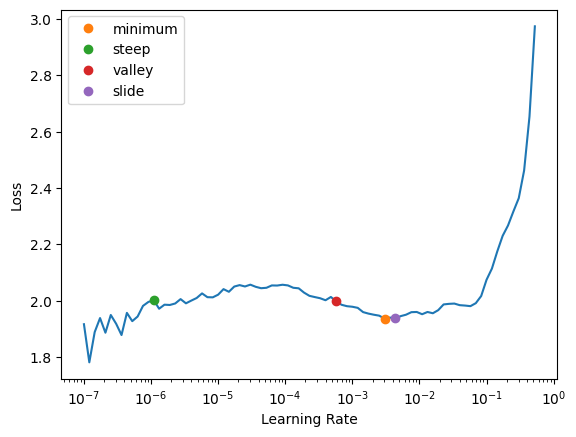

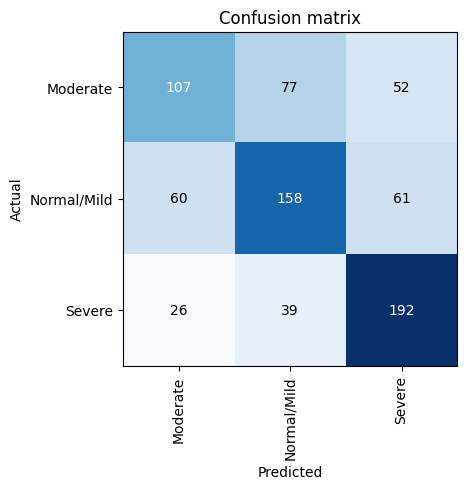

Training model for the column right_neural_foraminal_narrowing_l5_s1 
Length of data training: 3858


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.0013182567432522773, steep: 1.0964781722577754e-06, valley: 0.0012022644514217973, slide: 0.0030199517495930195


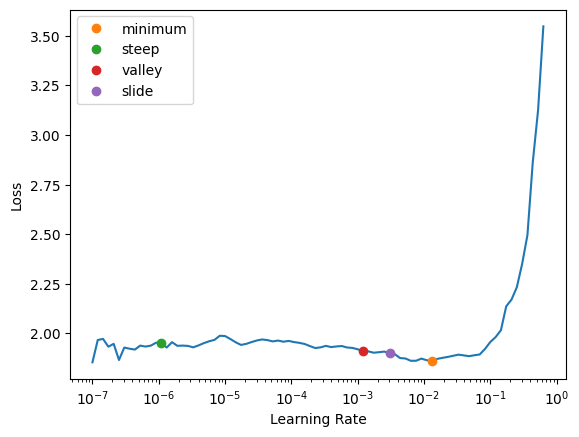

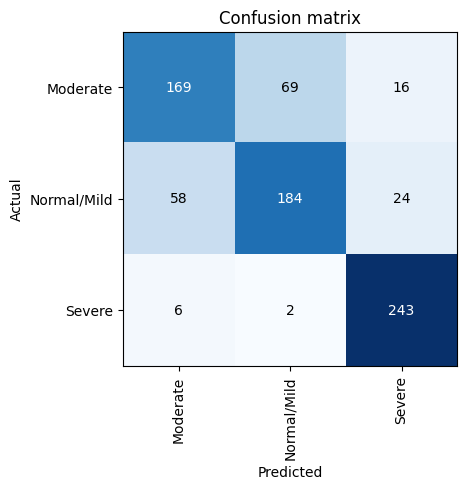

New path creation for column left_subarticular_stenosis_l1_l2.
Preprocessing data (upsampling) for  left_subarticular_stenosis_l1_l2
Length stats of  left_subarticular_stenosis_l1_l2 : 1695   1695   1695
Preparing image paths and labels for current column


100%|██████████| 1000/1000 [04:58<00:00,  3.35it/s]


Saved batch 0 to /kaggle/working/CurrentLabels/left_subarticular_stenosis_l1_l2_image_paths_labels.csv_batch_0.csv


100%|██████████| 1000/1000 [04:42<00:00,  3.54it/s]


Saved batch 1 to /kaggle/working/CurrentLabels/left_subarticular_stenosis_l1_l2_image_paths_labels.csv_batch_1.csv


100%|██████████| 1000/1000 [04:47<00:00,  3.48it/s]


Saved batch 2 to /kaggle/working/CurrentLabels/left_subarticular_stenosis_l1_l2_image_paths_labels.csv_batch_2.csv


100%|██████████| 1000/1000 [04:49<00:00,  3.45it/s]


Saved batch 3 to /kaggle/working/CurrentLabels/left_subarticular_stenosis_l1_l2_image_paths_labels.csv_batch_3.csv


100%|██████████| 1000/1000 [04:34<00:00,  3.65it/s]


Saved batch 4 to /kaggle/working/CurrentLabels/left_subarticular_stenosis_l1_l2_image_paths_labels.csv_batch_4.csv


100%|██████████| 85/85 [00:22<00:00,  3.72it/s]


Saved batch 5 to /kaggle/working/CurrentLabels/left_subarticular_stenosis_l1_l2_image_paths_labels.csv_batch_5.csv
Saved full dataset to /kaggle/working/CurrentLabels/left_subarticular_stenosis_l1_l2_image_paths_labels.csv
Processed and saved data for column: left_subarticular_stenosis_l1_l2 to /kaggle/working/CurrentLabels/left_subarticular_stenosis_l1_l2_image_paths_labels.csv


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.006918309628963471, steep: 9.12010818865383e-07, valley: 0.0004786300996784121, slide: 0.00363078061491251


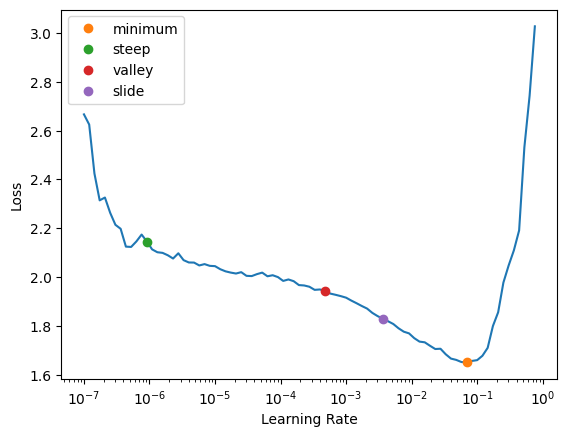

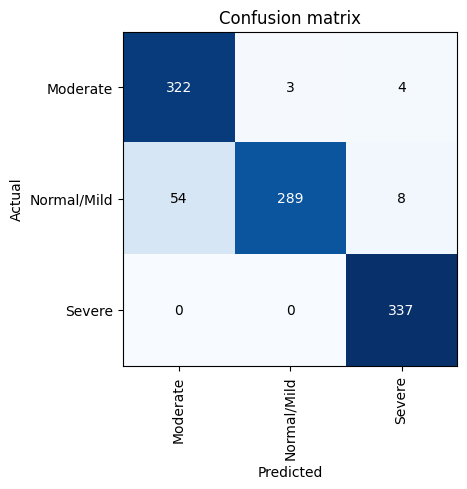

Training model for the column left_subarticular_stenosis_l1_l2 
Length of data training: 5085


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.005754399299621582, steep: 2.2908675418875646e-06, valley: 0.0014454397605732083, slide: 0.0030199517495930195


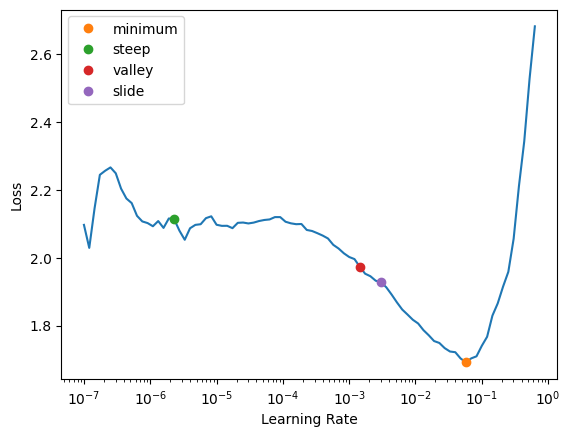

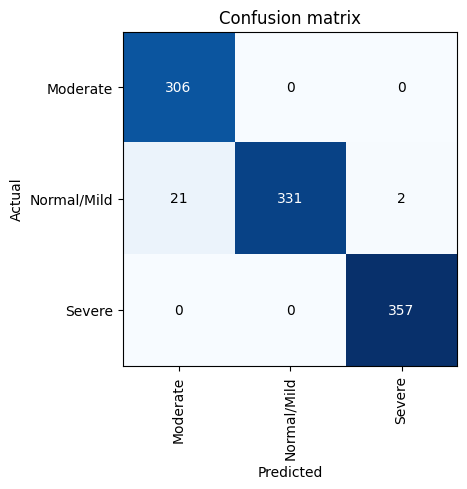

New path creation for column left_subarticular_stenosis_l2_l3.
Preprocessing data (upsampling) for  left_subarticular_stenosis_l2_l3
Length stats of  left_subarticular_stenosis_l2_l3 : 1560   1560   1560
Preparing image paths and labels for current column


100%|██████████| 1000/1000 [04:55<00:00,  3.39it/s]


Saved batch 0 to /kaggle/working/CurrentLabels/left_subarticular_stenosis_l2_l3_image_paths_labels.csv_batch_0.csv


100%|██████████| 1000/1000 [04:56<00:00,  3.38it/s]


Saved batch 1 to /kaggle/working/CurrentLabels/left_subarticular_stenosis_l2_l3_image_paths_labels.csv_batch_1.csv


100%|██████████| 1000/1000 [04:56<00:00,  3.38it/s]


Saved batch 2 to /kaggle/working/CurrentLabels/left_subarticular_stenosis_l2_l3_image_paths_labels.csv_batch_2.csv


100%|██████████| 1000/1000 [04:22<00:00,  3.81it/s]


Saved batch 3 to /kaggle/working/CurrentLabels/left_subarticular_stenosis_l2_l3_image_paths_labels.csv_batch_3.csv


100%|██████████| 680/680 [03:01<00:00,  3.75it/s]


Saved batch 4 to /kaggle/working/CurrentLabels/left_subarticular_stenosis_l2_l3_image_paths_labels.csv_batch_4.csv
Saved full dataset to /kaggle/working/CurrentLabels/left_subarticular_stenosis_l2_l3_image_paths_labels.csv
Processed and saved data for column: left_subarticular_stenosis_l2_l3 to /kaggle/working/CurrentLabels/left_subarticular_stenosis_l2_l3_image_paths_labels.csv


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.005754399299621582, steep: 2.2908675418875646e-06, valley: 0.0008317637839354575, slide: 0.0010000000474974513


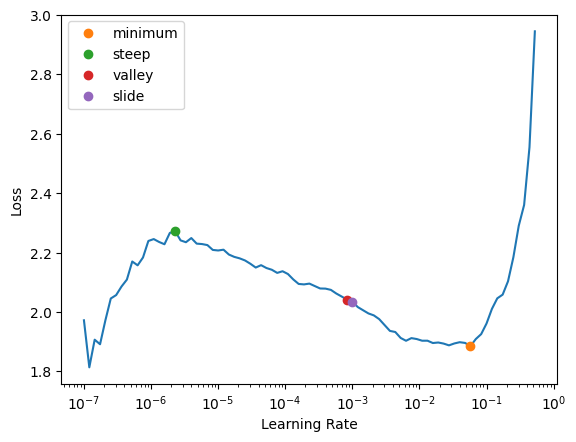

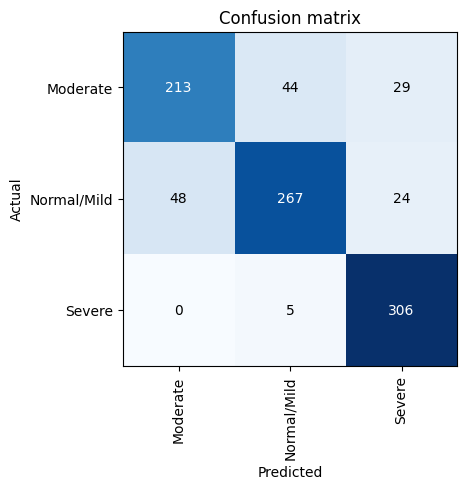

Training model for the column left_subarticular_stenosis_l2_l3 
Length of data training: 4680


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.0033113110810518267, steep: 1.9054607491852948e-06, valley: 0.002511886414140463, slide: 0.002511886414140463


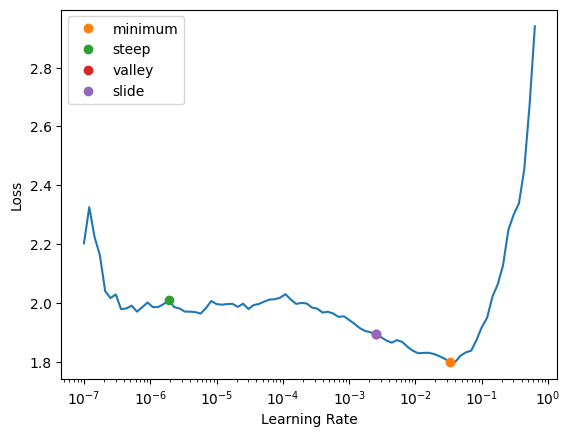

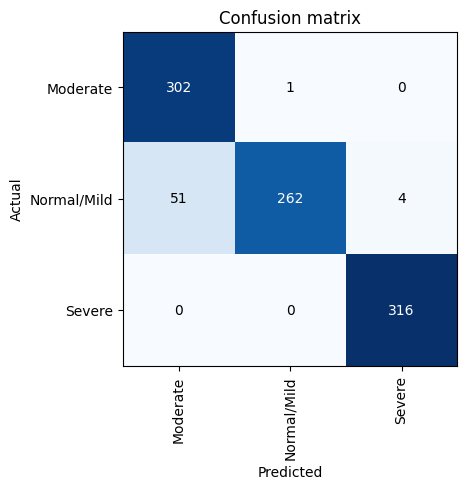

New path creation for column left_subarticular_stenosis_l3_l4.
Preprocessing data (upsampling) for  left_subarticular_stenosis_l3_l4
Length stats of  left_subarticular_stenosis_l3_l4 : 1327   1327   1327
Preparing image paths and labels for current column


100%|██████████| 1000/1000 [05:03<00:00,  3.30it/s]


Saved batch 0 to /kaggle/working/CurrentLabels/left_subarticular_stenosis_l3_l4_image_paths_labels.csv_batch_0.csv


100%|██████████| 1000/1000 [04:52<00:00,  3.42it/s]


Saved batch 1 to /kaggle/working/CurrentLabels/left_subarticular_stenosis_l3_l4_image_paths_labels.csv_batch_1.csv


100%|██████████| 1000/1000 [04:52<00:00,  3.41it/s]


Saved batch 2 to /kaggle/working/CurrentLabels/left_subarticular_stenosis_l3_l4_image_paths_labels.csv_batch_2.csv


100%|██████████| 981/981 [05:10<00:00,  3.16it/s]


Saved batch 3 to /kaggle/working/CurrentLabels/left_subarticular_stenosis_l3_l4_image_paths_labels.csv_batch_3.csv
Saved full dataset to /kaggle/working/CurrentLabels/left_subarticular_stenosis_l3_l4_image_paths_labels.csv
Processed and saved data for column: left_subarticular_stenosis_l3_l4 to /kaggle/working/CurrentLabels/left_subarticular_stenosis_l3_l4_image_paths_labels.csv


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.0033113110810518267, steep: 7.585775892948732e-05, valley: 0.0012022644514217973, slide: 0.00363078061491251


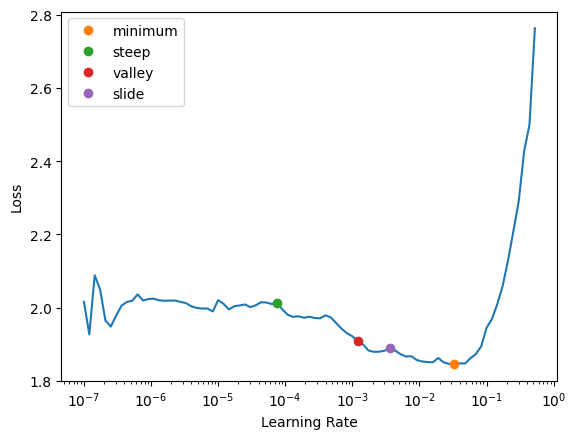

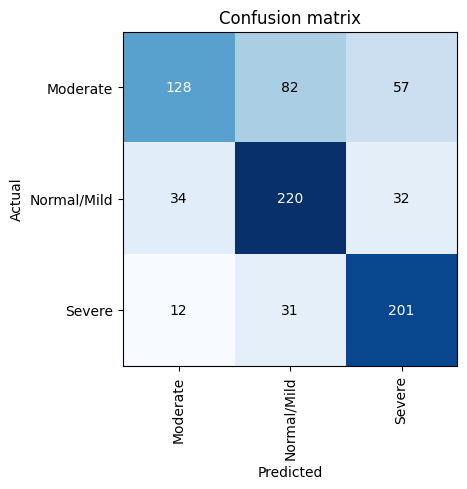

Training model for the column left_subarticular_stenosis_l3_l4 
Length of data training: 3981


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.0015848932787775993, steep: 7.585775847473997e-07, valley: 0.0012022644514217973, slide: 0.0004786300996784121


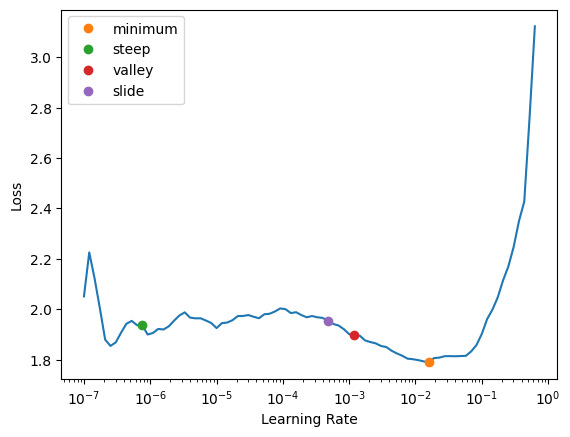

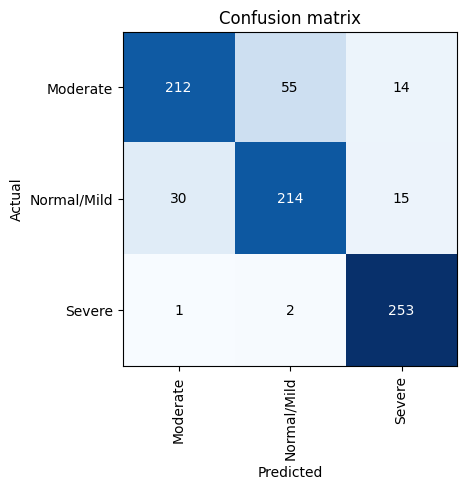

New path creation for column left_subarticular_stenosis_l4_l5.
Preprocessing data (upsampling) for  left_subarticular_stenosis_l4_l5
Length stats of  left_subarticular_stenosis_l4_l5 : 891   891   891
Preparing image paths and labels for current column


100%|██████████| 1000/1000 [04:53<00:00,  3.41it/s]


Saved batch 0 to /kaggle/working/CurrentLabels/left_subarticular_stenosis_l4_l5_image_paths_labels.csv_batch_0.csv


100%|██████████| 1000/1000 [05:05<00:00,  3.27it/s]


Saved batch 1 to /kaggle/working/CurrentLabels/left_subarticular_stenosis_l4_l5_image_paths_labels.csv_batch_1.csv


100%|██████████| 673/673 [03:35<00:00,  3.12it/s]
/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Saved batch 2 to /kaggle/working/CurrentLabels/left_subarticular_stenosis_l4_l5_image_paths_labels.csv_batch_2.csv
Saved full dataset to /kaggle/working/CurrentLabels/left_subarticular_stenosis_l4_l5_image_paths_labels.csv
Processed and saved data for column: left_subarticular_stenosis_l4_l5 to /kaggle/working/CurrentLabels/left_subarticular_stenosis_l4_l5_image_paths_labels.csv


Suggested learning rates - min: 0.0015848932787775993, steep: 9.12010818865383e-07, valley: 0.001737800776027143, slide: 0.004365158267319202


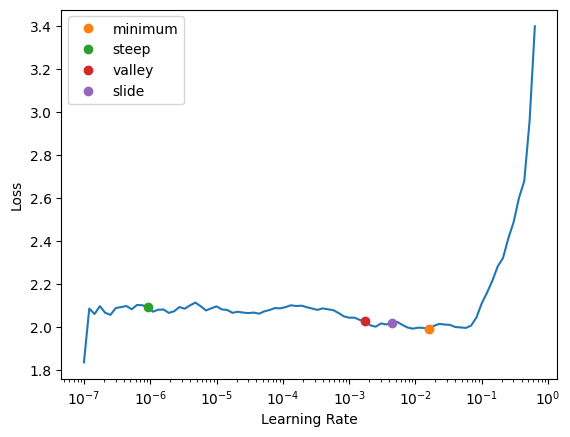

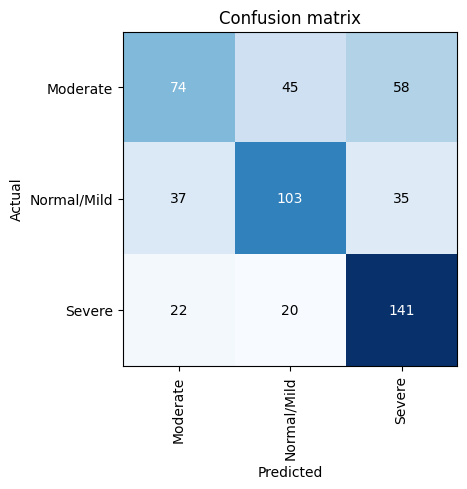

Training model for the column left_subarticular_stenosis_l4_l5 
Length of data training: 2673


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.001096478197723627, steep: 9.12010818865383e-07, valley: 0.0006918309954926372, slide: 0.0030199517495930195


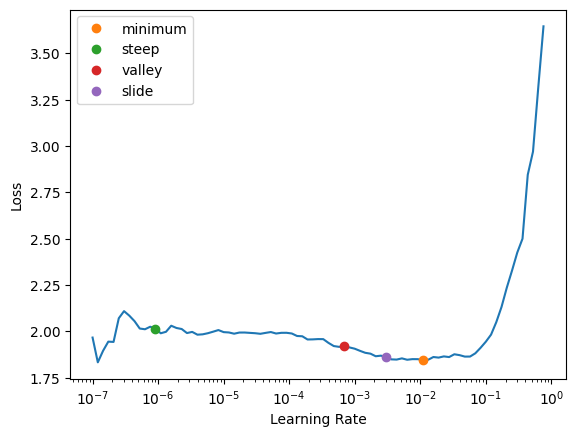

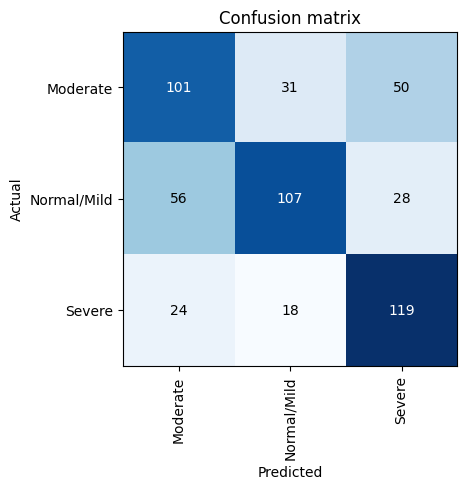

New path creation for column left_subarticular_stenosis_l5_s1.
Preprocessing data (upsampling) for  left_subarticular_stenosis_l5_s1
Length stats of  left_subarticular_stenosis_l5_s1 : 1413   1413   1413
Preparing image paths and labels for current column


100%|██████████| 1000/1000 [04:57<00:00,  3.36it/s]


Saved batch 0 to /kaggle/working/CurrentLabels/left_subarticular_stenosis_l5_s1_image_paths_labels.csv_batch_0.csv


100%|██████████| 1000/1000 [05:00<00:00,  3.33it/s]


Saved batch 1 to /kaggle/working/CurrentLabels/left_subarticular_stenosis_l5_s1_image_paths_labels.csv_batch_1.csv


100%|██████████| 1000/1000 [04:59<00:00,  3.34it/s]


Saved batch 2 to /kaggle/working/CurrentLabels/left_subarticular_stenosis_l5_s1_image_paths_labels.csv_batch_2.csv


100%|██████████| 1000/1000 [04:58<00:00,  3.34it/s]


Saved batch 3 to /kaggle/working/CurrentLabels/left_subarticular_stenosis_l5_s1_image_paths_labels.csv_batch_3.csv


100%|██████████| 239/239 [01:12<00:00,  3.29it/s]


Saved batch 4 to /kaggle/working/CurrentLabels/left_subarticular_stenosis_l5_s1_image_paths_labels.csv_batch_4.csv
Saved full dataset to /kaggle/working/CurrentLabels/left_subarticular_stenosis_l5_s1_image_paths_labels.csv
Processed and saved data for column: left_subarticular_stenosis_l5_s1 to /kaggle/working/CurrentLabels/left_subarticular_stenosis_l5_s1_image_paths_labels.csv


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.004786301031708717, steep: 1.3182567499825382e-06, valley: 0.004365158267319202, slide: 0.004365158267319202


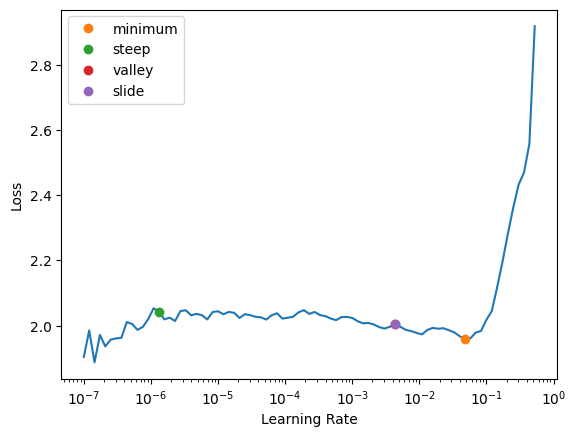

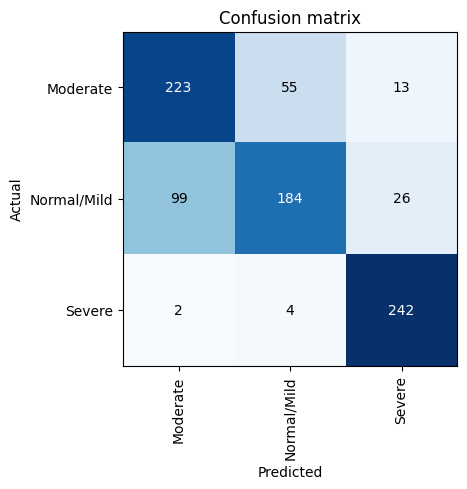

Training model for the column left_subarticular_stenosis_l5_s1 
Length of data training: 4239


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.0006309573538601399, steep: 6.309573450380412e-07, valley: 0.0003981071640737355, slide: 0.0020892962347716093


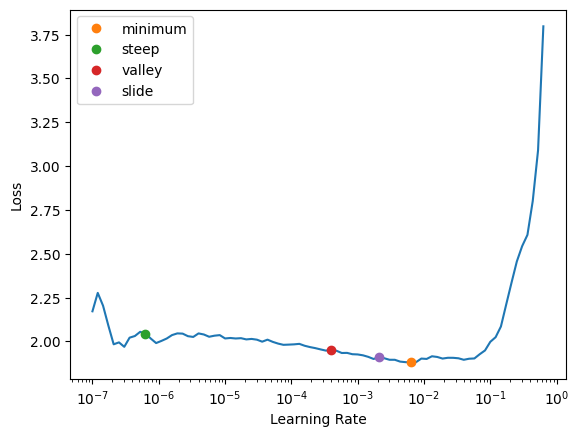

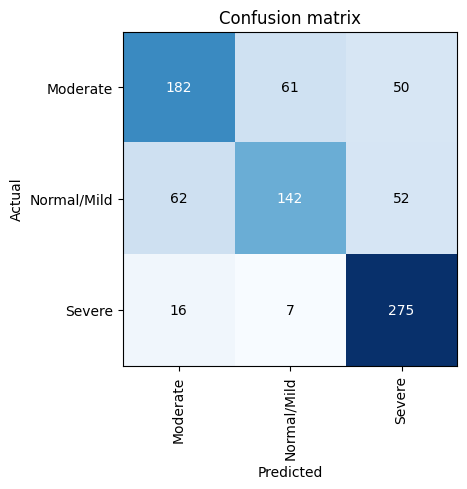

New path creation for column right_subarticular_stenosis_l1_l2.
Preprocessing data (upsampling) for  right_subarticular_stenosis_l1_l2
Length stats of  right_subarticular_stenosis_l1_l2 : 1686   1686   1686
Preparing image paths and labels for current column


100%|██████████| 1000/1000 [04:56<00:00,  3.37it/s]


Saved batch 0 to /kaggle/working/CurrentLabels/right_subarticular_stenosis_l1_l2_image_paths_labels.csv_batch_0.csv


100%|██████████| 1000/1000 [04:46<00:00,  3.50it/s]


Saved batch 1 to /kaggle/working/CurrentLabels/right_subarticular_stenosis_l1_l2_image_paths_labels.csv_batch_1.csv


100%|██████████| 1000/1000 [04:40<00:00,  3.56it/s]


Saved batch 2 to /kaggle/working/CurrentLabels/right_subarticular_stenosis_l1_l2_image_paths_labels.csv_batch_2.csv


100%|██████████| 1000/1000 [05:10<00:00,  3.22it/s]


Saved batch 3 to /kaggle/working/CurrentLabels/right_subarticular_stenosis_l1_l2_image_paths_labels.csv_batch_3.csv


100%|██████████| 1000/1000 [05:32<00:00,  3.01it/s]


Saved batch 4 to /kaggle/working/CurrentLabels/right_subarticular_stenosis_l1_l2_image_paths_labels.csv_batch_4.csv


100%|██████████| 58/58 [00:16<00:00,  3.46it/s]


Saved batch 5 to /kaggle/working/CurrentLabels/right_subarticular_stenosis_l1_l2_image_paths_labels.csv_batch_5.csv
Saved full dataset to /kaggle/working/CurrentLabels/right_subarticular_stenosis_l1_l2_image_paths_labels.csv
Processed and saved data for column: right_subarticular_stenosis_l1_l2 to /kaggle/working/CurrentLabels/right_subarticular_stenosis_l1_l2_image_paths_labels.csv


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.00831763744354248, steep: 0.004365158267319202, valley: 0.0012022644514217973, slide: 0.004365158267319202


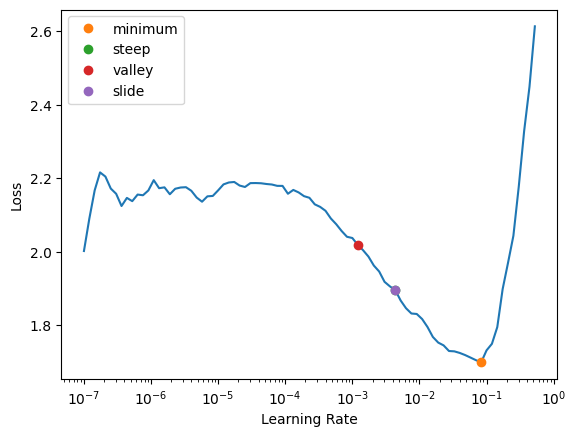

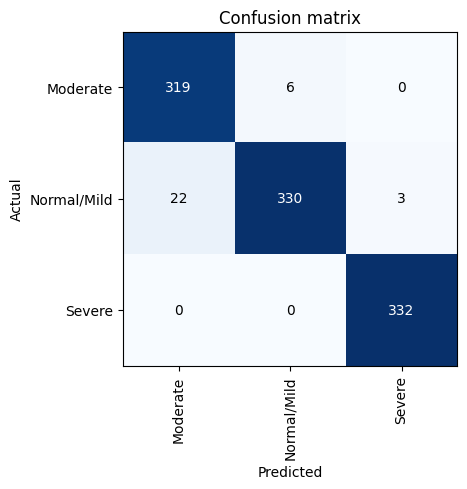

Training model for the column right_subarticular_stenosis_l1_l2 
Length of data training: 5058


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.005754399299621582, steep: 0.002511886414140463, valley: 0.0012022644514217973, slide: 0.0020892962347716093


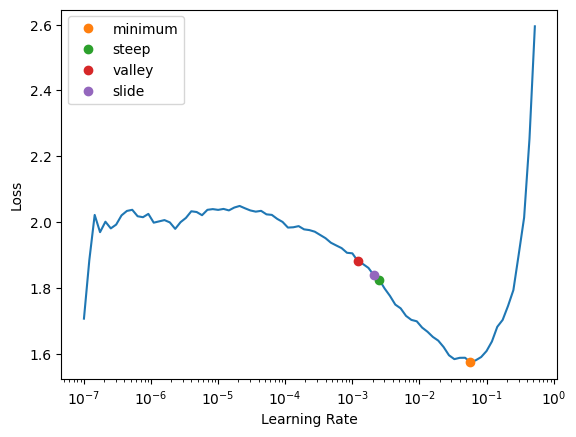

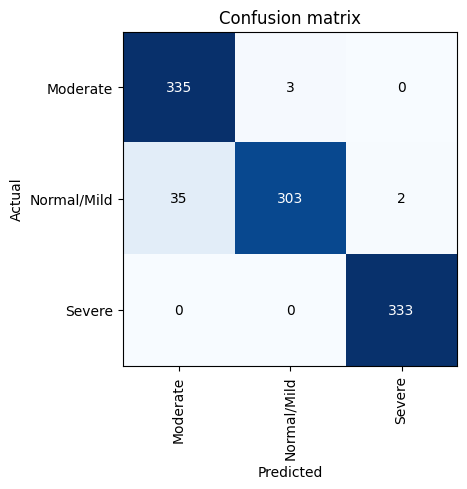

New path creation for column right_subarticular_stenosis_l2_l3.
Preprocessing data (upsampling) for  right_subarticular_stenosis_l2_l3
Length stats of  right_subarticular_stenosis_l2_l3 : 1581   1581   1581
Preparing image paths and labels for current column


100%|██████████| 1000/1000 [04:58<00:00,  3.35it/s]


Saved batch 0 to /kaggle/working/CurrentLabels/right_subarticular_stenosis_l2_l3_image_paths_labels.csv_batch_0.csv


100%|██████████| 1000/1000 [04:47<00:00,  3.48it/s]


Saved batch 1 to /kaggle/working/CurrentLabels/right_subarticular_stenosis_l2_l3_image_paths_labels.csv_batch_1.csv


100%|██████████| 1000/1000 [04:37<00:00,  3.60it/s]


Saved batch 2 to /kaggle/working/CurrentLabels/right_subarticular_stenosis_l2_l3_image_paths_labels.csv_batch_2.csv


100%|██████████| 1000/1000 [05:10<00:00,  3.22it/s]


Saved batch 3 to /kaggle/working/CurrentLabels/right_subarticular_stenosis_l2_l3_image_paths_labels.csv_batch_3.csv


100%|██████████| 743/743 [03:55<00:00,  3.16it/s]


Saved batch 4 to /kaggle/working/CurrentLabels/right_subarticular_stenosis_l2_l3_image_paths_labels.csv_batch_4.csv
Saved full dataset to /kaggle/working/CurrentLabels/right_subarticular_stenosis_l2_l3_image_paths_labels.csv
Processed and saved data for column: right_subarticular_stenosis_l2_l3 to /kaggle/working/CurrentLabels/right_subarticular_stenosis_l2_l3_image_paths_labels.csv


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.005754399299621582, steep: 1.0964781722577754e-06, valley: 0.0008317637839354575, slide: 0.002511886414140463


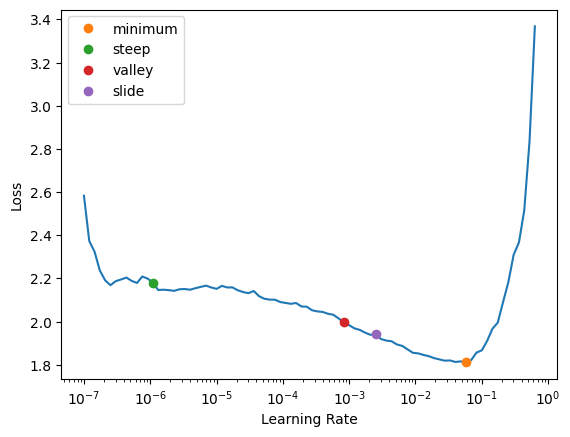

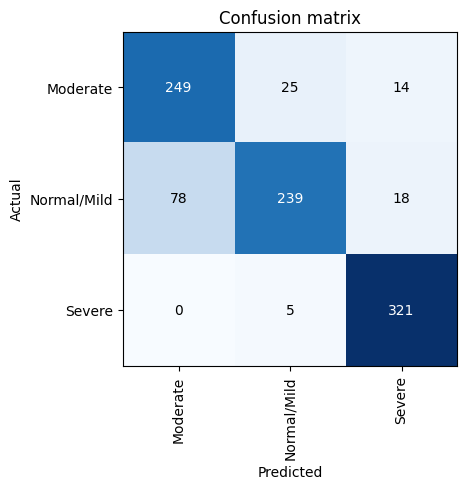

Training model for the column right_subarticular_stenosis_l2_l3 
Length of data training: 4743


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.005754399299621582, steep: 0.0002754228771664202, valley: 0.0010000000474974513, slide: 0.002511886414140463


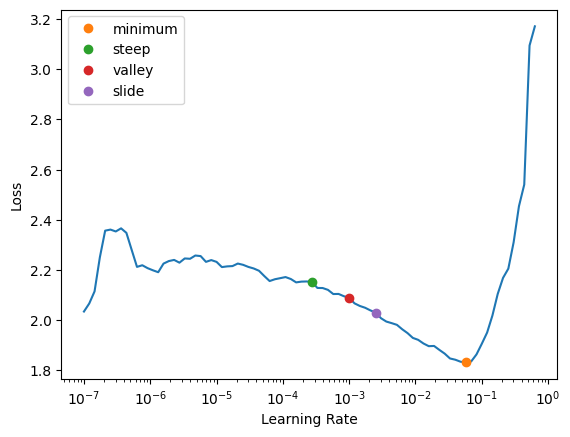

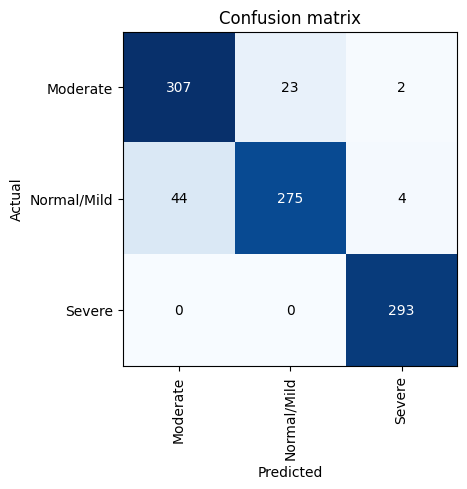

New path creation for column right_subarticular_stenosis_l3_l4.
Preprocessing data (upsampling) for  right_subarticular_stenosis_l3_l4
Length stats of  right_subarticular_stenosis_l3_l4 : 1321   1321   1321
Preparing image paths and labels for current column


100%|██████████| 1000/1000 [04:58<00:00,  3.35it/s]


Saved batch 0 to /kaggle/working/CurrentLabels/right_subarticular_stenosis_l3_l4_image_paths_labels.csv_batch_0.csv


100%|██████████| 1000/1000 [04:59<00:00,  3.34it/s]


Saved batch 1 to /kaggle/working/CurrentLabels/right_subarticular_stenosis_l3_l4_image_paths_labels.csv_batch_1.csv


100%|██████████| 1000/1000 [04:53<00:00,  3.41it/s]


Saved batch 2 to /kaggle/working/CurrentLabels/right_subarticular_stenosis_l3_l4_image_paths_labels.csv_batch_2.csv


100%|██████████| 963/963 [04:59<00:00,  3.22it/s]


Saved batch 3 to /kaggle/working/CurrentLabels/right_subarticular_stenosis_l3_l4_image_paths_labels.csv_batch_3.csv
Saved full dataset to /kaggle/working/CurrentLabels/right_subarticular_stenosis_l3_l4_image_paths_labels.csv
Processed and saved data for column: right_subarticular_stenosis_l3_l4 to /kaggle/working/CurrentLabels/right_subarticular_stenosis_l3_l4_image_paths_labels.csv


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.0006309573538601399, steep: 5.754399353463668e-06, valley: 0.0014454397605732083, slide: 0.00363078061491251


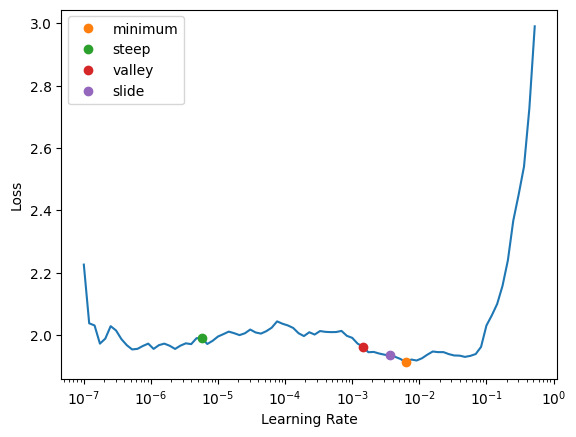

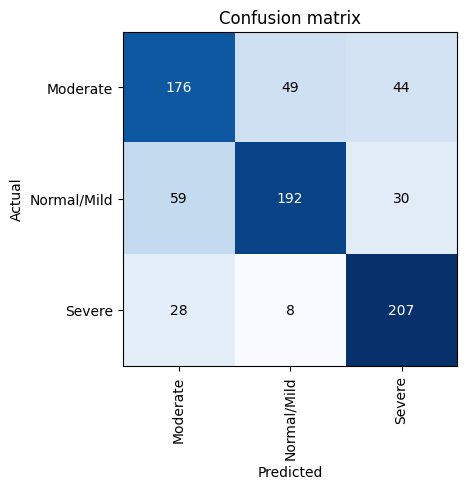

Training model for the column right_subarticular_stenosis_l3_l4 
Length of data training: 3963


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.004786301031708717, steep: 1.9054607491852948e-06, valley: 0.004365158267319202, slide: 0.0030199517495930195


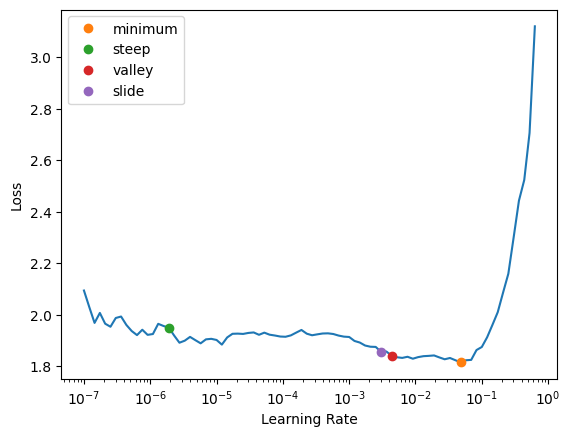

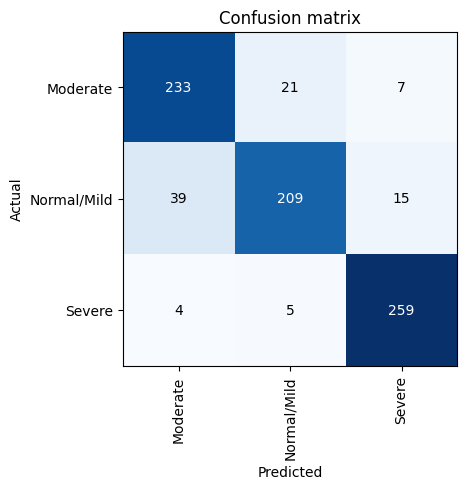

New path creation for column right_subarticular_stenosis_l4_l5.
Preprocessing data (upsampling) for  right_subarticular_stenosis_l4_l5
Length stats of  right_subarticular_stenosis_l4_l5 : 890   890   890
Preparing image paths and labels for current column


100%|██████████| 1000/1000 [04:57<00:00,  3.36it/s]


Saved batch 0 to /kaggle/working/CurrentLabels/right_subarticular_stenosis_l4_l5_image_paths_labels.csv_batch_0.csv


100%|██████████| 1000/1000 [04:57<00:00,  3.36it/s]


Saved batch 1 to /kaggle/working/CurrentLabels/right_subarticular_stenosis_l4_l5_image_paths_labels.csv_batch_1.csv


100%|██████████| 670/670 [03:26<00:00,  3.24it/s]
/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Saved batch 2 to /kaggle/working/CurrentLabels/right_subarticular_stenosis_l4_l5_image_paths_labels.csv_batch_2.csv
Saved full dataset to /kaggle/working/CurrentLabels/right_subarticular_stenosis_l4_l5_image_paths_labels.csv
Processed and saved data for column: right_subarticular_stenosis_l4_l5 to /kaggle/working/CurrentLabels/right_subarticular_stenosis_l4_l5_image_paths_labels.csv


Suggested learning rates - min: 6.309573450380412e-08, steep: 0.0002754228771664202, valley: 0.001737800776027143, slide: 0.00363078061491251


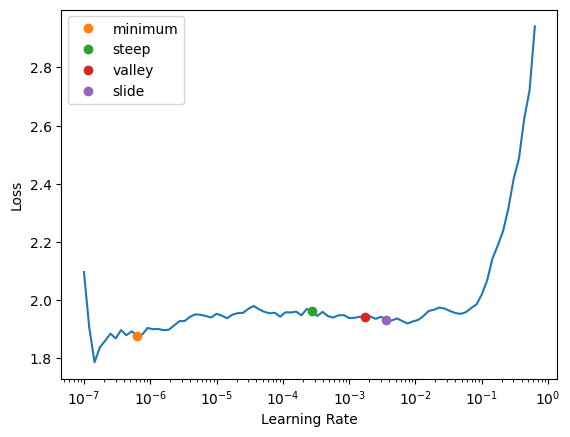

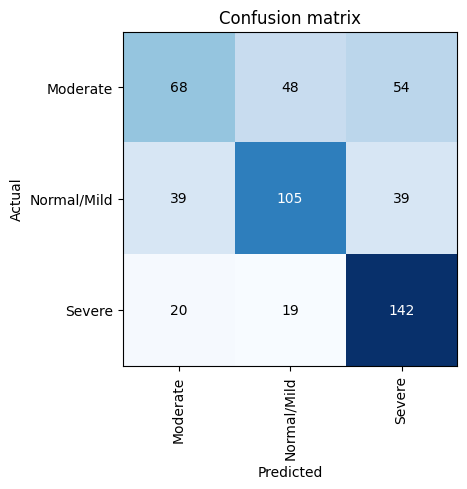

Training model for the column right_subarticular_stenosis_l4_l5 
Length of data training: 2670


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.0015848932787775993, steep: 9.999999747378752e-06, valley: 0.0010000000474974513, slide: 0.0030199517495930195


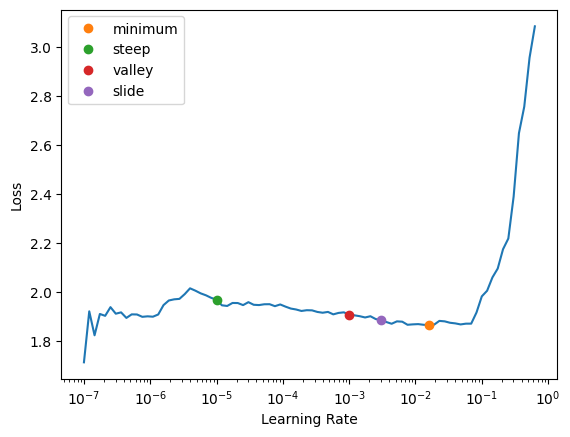

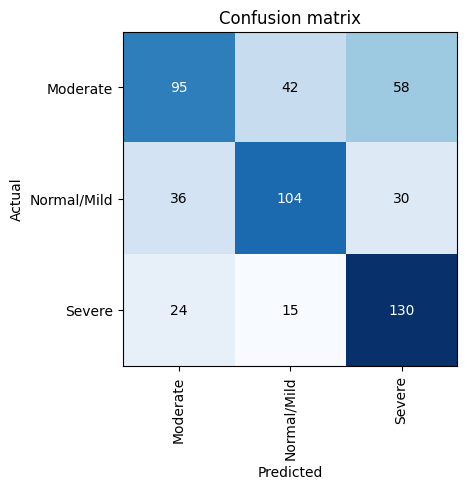

New path creation for column right_subarticular_stenosis_l5_s1.
Preprocessing data (upsampling) for  right_subarticular_stenosis_l5_s1
Length stats of  right_subarticular_stenosis_l5_s1 : 1402   1402   1402
Preparing image paths and labels for current column


100%|██████████| 1000/1000 [05:01<00:00,  3.31it/s]


Saved batch 0 to /kaggle/working/CurrentLabels/right_subarticular_stenosis_l5_s1_image_paths_labels.csv_batch_0.csv


100%|██████████| 1000/1000 [04:49<00:00,  3.46it/s]


Saved batch 1 to /kaggle/working/CurrentLabels/right_subarticular_stenosis_l5_s1_image_paths_labels.csv_batch_1.csv


100%|██████████| 1000/1000 [04:52<00:00,  3.41it/s]


Saved batch 2 to /kaggle/working/CurrentLabels/right_subarticular_stenosis_l5_s1_image_paths_labels.csv_batch_2.csv


100%|██████████| 1000/1000 [05:01<00:00,  3.32it/s]


Saved batch 3 to /kaggle/working/CurrentLabels/right_subarticular_stenosis_l5_s1_image_paths_labels.csv_batch_3.csv


100%|██████████| 206/206 [01:04<00:00,  3.18it/s]


Saved batch 4 to /kaggle/working/CurrentLabels/right_subarticular_stenosis_l5_s1_image_paths_labels.csv_batch_4.csv
Saved full dataset to /kaggle/working/CurrentLabels/right_subarticular_stenosis_l5_s1_image_paths_labels.csv
Processed and saved data for column: right_subarticular_stenosis_l5_s1 to /kaggle/working/CurrentLabels/right_subarticular_stenosis_l5_s1_image_paths_labels.csv


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.004786301031708717, steep: 1.3182567499825382e-06, valley: 0.00363078061491251, slide: 0.002511886414140463


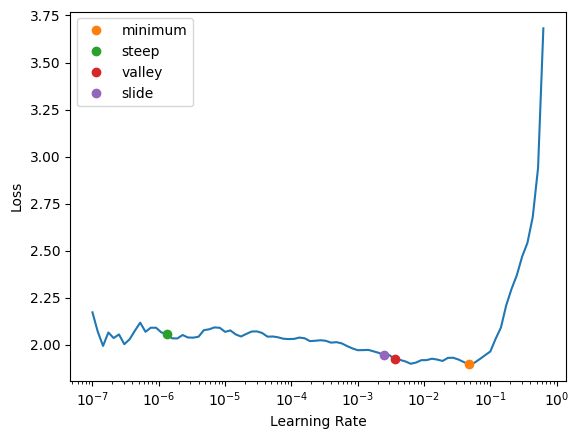

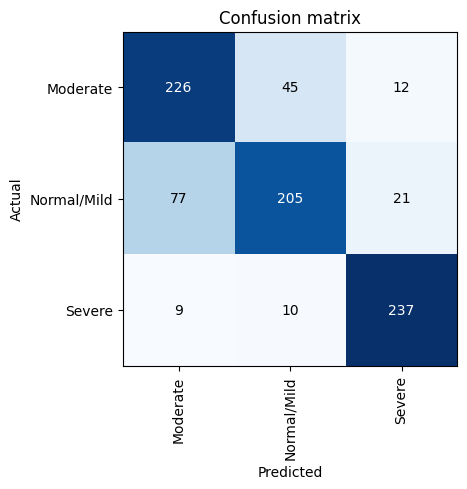

Training model for the column right_subarticular_stenosis_l5_s1 
Length of data training: 4206


/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Suggested learning rates - min: 0.005754399299621582, steep: 6.309573450380412e-07, valley: 0.007585775572806597, slide: 0.00363078061491251


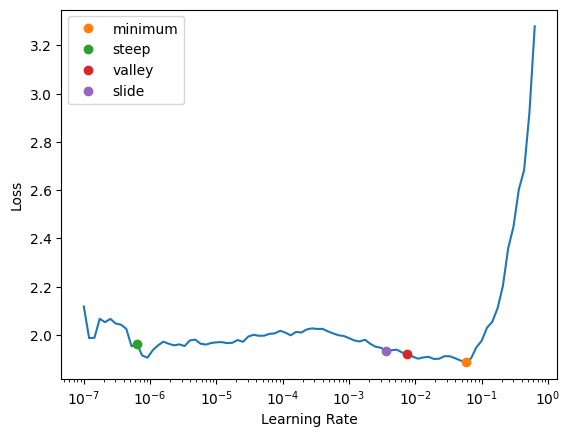

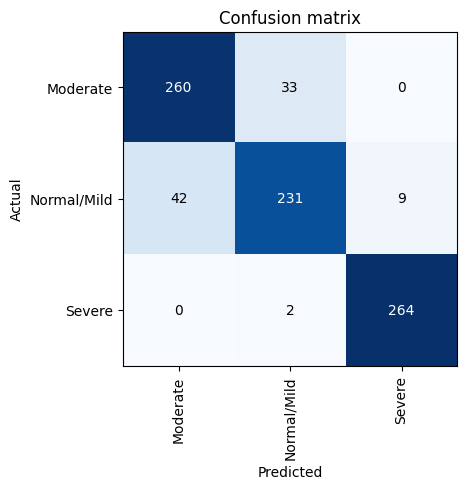

In [11]:
# Process and train models
models = preprocess_and_train(train, columns_to_predict, temp_image_dir)

In [12]:
# Predict on test data for each column (do the same as above)
test_image_dir = "/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/44036939/"
test_image_paths = []
for series_id in ["2828203845", "3481971518", "3844393089"]:                 #("2828203845" is sagittal T1 images, but trying to implement this model for other types of images too - which is not needed)
    series_folder = os.path.join(test_image_dir, series_id)
    dicom_stack = load_dicom_stack(series_folder, plane="sagittal", reverse_sort=True)
    middle_slice = dicom_stack["array"][len(dicom_stack["array"]) // 2]
    image_path = f"/tmp/test_{series_id}.png"
    plt.imsave(image_path, middle_slice, cmap="gray")
    test_image_paths.append(image_path)

# Store results for each column
results = {}
for column in columns_to_predict:
    test_data = pd.DataFrame({"image": test_image_paths})
    test_dl = models[column].dls.test_dl(test_data)
    preds, _ = models[column].get_preds(dl=test_dl)
    pred_labels = [models[column].dls.vocab[p] for p in preds.argmax(dim=1)]
    
    column_results = []
    for img_path, pred_label in zip(test_image_paths, pred_labels):
        parts = os.path.basename(img_path).split("_")
        series_id = parts[1].split(".")[0]
        column_results.append({"study_id": "44036939", "series_id": series_id, "image": img_path, "predicted_label": pred_label})
    
    results[column] = column_results

# Save results to CSV files for each column
for column, column_results in results.items():
    results_df = pd.DataFrame(column_results)
    output_path = f"/kaggle/working/{column}_predictions.csv"
    results_df.to_csv(output_path, index=False)
    print(f"Results for {column} saved to {output_path}")



Results for spinal_canal_stenosis_l1_l2 saved to /kaggle/working/spinal_canal_stenosis_l1_l2_predictions.csv
Results for spinal_canal_stenosis_l2_l3 saved to /kaggle/working/spinal_canal_stenosis_l2_l3_predictions.csv
Results for spinal_canal_stenosis_l3_l4 saved to /kaggle/working/spinal_canal_stenosis_l3_l4_predictions.csv
Results for spinal_canal_stenosis_l4_l5 saved to /kaggle/working/spinal_canal_stenosis_l4_l5_predictions.csv
Results for spinal_canal_stenosis_l5_s1 saved to /kaggle/working/spinal_canal_stenosis_l5_s1_predictions.csv
Results for left_neural_foraminal_narrowing_l1_l2 saved to /kaggle/working/left_neural_foraminal_narrowing_l1_l2_predictions.csv
Results for left_neural_foraminal_narrowing_l2_l3 saved to /kaggle/working/left_neural_foraminal_narrowing_l2_l3_predictions.csv
Results for left_neural_foraminal_narrowing_l3_l4 saved to /kaggle/working/left_neural_foraminal_narrowing_l3_l4_predictions.csv
Results for left_neural_foraminal_narrowing_l4_l5 saved to /kaggle/w

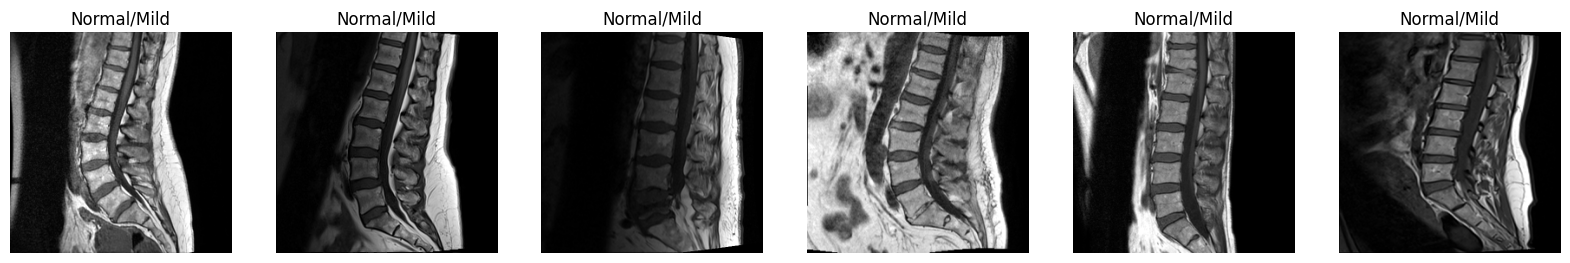

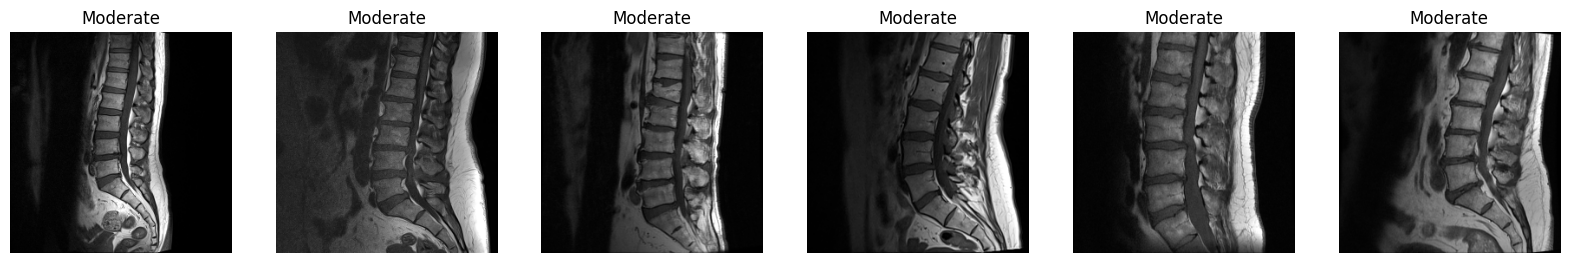

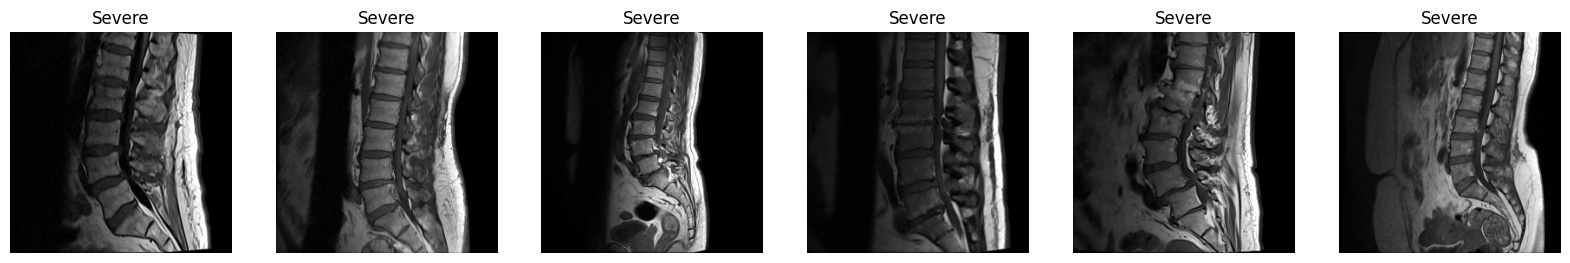

In [13]:
# Display some images from each category
data2 = pd.concat([pd.read_csv(os.path.join(temp_image_dir, f"{column}_image_paths_labels.csv")) for column in columns_to_predict])
for category in ['Normal/Mild', 'Moderate', 'Severe']:
    show_images_from_category(data2, category, n=6)